>[Исследование объявлений о продаже квартир](#scrollTo=6stm78OHz8q9)

>>[Общая информация.](#scrollTo=nMqb9JKmz8q-)

>>[Предобработка данных](#scrollTo=alJjulLPz8rB)

>>>[Заполнение пропусков](#scrollTo=2GyJa66sz8rC)

>>>[Преобразование форматов](#scrollTo=XsiB9Imaz8rH)

>>>[Проверка некорректных значений](#scrollTo=O6NYIcn1z8rL)

>>>[Добавление новых столбцов, необходимых для анализа](#scrollTo=3QzOmzAzz8rR)

>>[Исследовательский анализ данных](#scrollTo=JZFCeoEOz8rV)

>>[Вывод](#scrollTo=hd2ymsBgz8ra)



# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо установить параметры определяющие рыночную стоимость объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**Цель исследования** - определение факторов, влияющих на рыночную стоимость объектов недвижимости

**Оцениваемы параметры**:  

* общая площадь
* жилая площадь
* площадь кухни
* количество комнат
* дата размещения
 * день недели
 * месяц
 * год
* этаж квартиры
* населенный пункт
* расстояние от центра города 

**План исследования**

 * изучить параметры и выявить с какими характеристиками объявления встречаются чаще всего
 * изучить как быстро продаются квартиры и определить средний срок продажи объявлениq
 * выявить каким образом вышеперечисленные параметры влияют на стомость продажи объекта


## Общая информация. 

In [283]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format

In [284]:

#загрузим данные
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv',  sep='\t')

In [285]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


In [286]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Итак, в таблице двенадцать столбцов. Тип данных в столбцах с текстом — object. В столбцах с числами int64 и float64.  

* `first_day_exposition` должен быть в формате даты  
* `days_exposition` должен быть int64  
Остальное, на первый взгляд, верно.

Согласно документации к данным:

* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)  
* `balcony` — число балконов  
* `ceiling_height` — высота потолков (м)  
* `cityCenters_nearest` — расстояние до центра города (м)   
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)  
* `first_day_exposition` — дата публикации  
* `floor` — этаж  
* `floors_total` — всего этажей в доме  
* `is_apartment` — апартаменты (булев тип)  
* `kitchen_area` — площадь кухни в квадратных метрах (м²)  
* `last_price` — цена на момент снятия с публикации  
* `living_area` — жилая площадь в квадратных метрах (м²)  
* `locality_name` — название населённого пункта  
* `open_plan` — свободная планировка (булев тип)  
* `parks_around3000` — число парков в радиусе 3 км  
* `parks_nearest` — расстояние до ближайшего парка (м)  
* `ponds_around3000` — число водоёмов в радиусе 3 км  
* `ponds_nearest` — расстояние до ближайшего водоёма (м)  
* `rooms` — число комнат  
* `studio` — квартира-студия (булев тип)  
* `total_area` — общая площадь квартиры в квадратных метрах (м²)  
* `total_images` — число фотографий квартиры в объявлении  

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.


## Предобработка данных

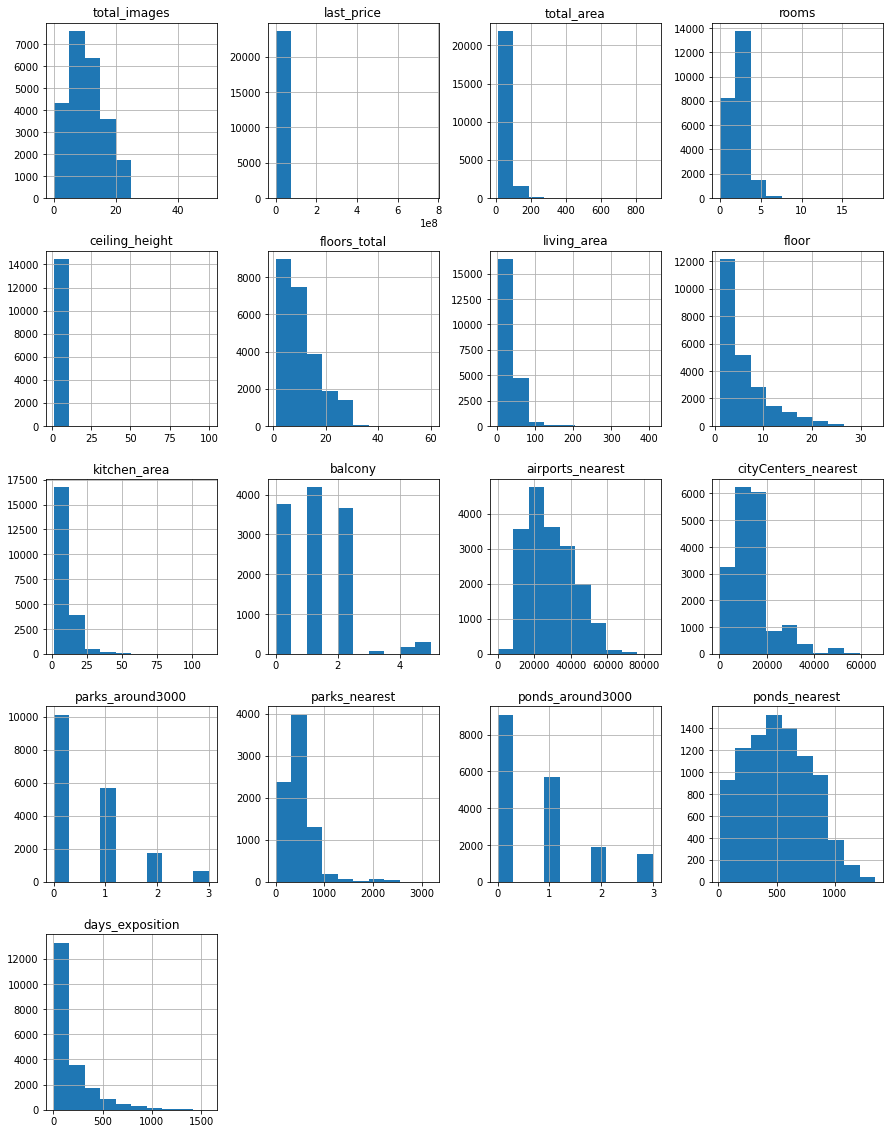

In [287]:
#Построим гистограмму для всех столбцов таблицы, для общего понимания распределния значений в датафрейме
data.hist(figsize=(15, 20));

Есть выбросы по параметрам `last_price`, `total_area`, `living_area`, `ceiling_height`, `kitchen_area`,  подозрительно высокие значения параметров `floors_total`, `days_exposition`.  

Подробнее рассмотрим ниже.

In [288]:
#посчитаем пропуски
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [289]:
#проверим нулевые значения
for i in data.columns.tolist():
    print(i,len(data[data[i]==0]))

                   

total_images 1059
last_price 0
total_area 0
first_day_exposition 0
rooms 197
ceiling_height 0
floors_total 0
living_area 0
floor 0
is_apartment 2725
studio 23550
open_plan 23632
kitchen_area 0
balcony 3758
locality_name 0
airports_nearest 1
cityCenters_nearest 0
parks_around3000 10106
parks_nearest 0
ponds_around3000 9071
ponds_nearest 0
days_exposition 0


### Заполнение пропусков

In [290]:
#посмотрим на пропуски в столбцах с населенным пунктом
data[data['locality_name'].isna()].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,"8,600,000.00",81.70,2016-04-15T00:00:00,3,3.55,5.00,50.80,2,NaN,...,8.80,0.00,NaN,"23,478.00","4,258.00",0.00,NaN,0.00,NaN,147.00
2033,6,"5,398,000.00",80.00,2017-05-30T00:00:00,3,NaN,4.00,42.60,2,NaN,...,18.60,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.00
2603,20,"3,351,765.00",42.70,2015-09-20T00:00:00,1,NaN,24.00,15.60,3,NaN,...,10.70,0.00,NaN,"22,041.00","17,369.00",0.00,NaN,1.00,374.00,276.00
2632,2,"5,130,593.00",62.40,2015-10-11T00:00:00,2,NaN,24.00,33.10,21,NaN,...,8.20,0.00,NaN,"22,041.00","17,369.00",0.00,NaN,1.00,374.00,256.00
3574,10,"4,200,000.00",46.50,2016-05-28T00:00:00,2,NaN,5.00,30.80,5,NaN,...,6.50,0.00,NaN,"27,419.00","8,127.00",0.00,NaN,1.00,603.00,45.00
4151,17,"17,600,000.00",89.50,2014-12-09T00:00:00,2,3.00,8.00,39.62,7,NaN,...,13.38,0.00,NaN,"25,054.00","3,902.00",1.00,485.00,3.00,722.00,869.00
4189,7,"9,200,000.00",80.00,2015-12-10T00:00:00,3,4.00,4.00,52.30,3,False,...,10.40,0.00,NaN,"21,774.00","3,039.00",1.00,690.00,1.00,953.00,223.00
4670,1,"5,500,000.00",83.00,2015-08-14T00:00:00,3,NaN,7.00,NaN,6,NaN,...,NaN,0.00,NaN,"26,534.00","5,382.00",1.00,446.00,1.00,376.00,350.00
5343,19,"13,540,000.00",85.50,2016-01-20T00:00:00,3,NaN,7.00,59.10,5,False,...,8.30,4.00,NaN,"10,556.00","9,538.00",1.00,67.00,0.00,NaN,303.00
5707,7,"3,700,000.00",30.00,2016-04-29T00:00:00,1,NaN,24.00,20.00,23,NaN,...,NaN,0.00,NaN,"21,460.00","16,788.00",0.00,NaN,1.00,170.00,49.00


Эти данные заполнить нам нечем, поэтому удалим эти строки

In [291]:
data = data.dropna(subset=['locality_name']).reset_index(drop=True)


Заполним пропуски по столбцу высота потолка медианным значением в соответствии с населенным пунктом, но только в том случае, если количество объявлений по населенному пункту примелимо.  
Посмотрим по каким нас.п. больше всего объявлений и как сиильно различается медиана.

In [292]:
data_count = data.pivot_table(index='locality_name', values='ceiling_height', aggfunc=['count','median'])

data_count.columns = ['count_ad', 'median']

data_count.sort_values(by='count_ad',ascending=False).head(35)

,count_ad,median
locality_name,,
Санкт-Петербург,10104,2.70
Всеволожск,272,2.70
Пушкин,234,2.60
посёлок Шушары,217,2.63
Колпино,203,2.50
посёлок Мурино,200,2.70
Гатчина,149,2.55
Петергоф,145,2.55
посёлок Парголово,137,2.64


Отличия есть, хоть и не значительные.  
Заполним пропуски в соответсвии с н.п. там, где кол-во объявлений более 50  
В остальных случаях общей медианой.
Также мы видим что есть неявные дубликаты по названиям, поэтому лучше сделать данное действие после их удаления.  
Вернемся ниже.  


In [293]:
#посмотрим на пропуски в столбцах с количеством этажей
data[data['floors_total'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,"11,640,000.00",65.20,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,"39,197.00","12,373.00",1.00,123.00,0.00,NaN,49.00
237,4,"2,438,033.00",28.10,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,NaN,...,NaN,0.00,Санкт-Петербург,"22,041.00","17,369.00",0.00,NaN,1.00,374.00,251.00
457,4,"9,788,348.00",70.80,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,NaN,...,10.63,0.00,Санкт-Петербург,"37,364.00","8,322.00",2.00,309.00,2.00,706.00,727.00
671,4,"6,051,191.00",93.60,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,NaN,...,16.80,0.00,Санкт-Петербург,"22,041.00","17,369.00",0.00,NaN,1.00,374.00,123.00
1756,5,"3,600,000.00",39.00,2017-04-22T00:00:00,1,NaN,NaN,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"22,735.00","11,618.00",1.00,835.00,1.00,652.00,77.00


In [294]:
# удалим их
data = data.dropna(subset=['floors_total'])

In [295]:
#посмотрим на данные, где количество комнат равно нулю
data.loc[data['rooms']==0].sort_values(by='living_area', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21186,0,"8,200,000.00",71.00,2017-07-21T00:00:00,0,5.80,5.00,68.00,5,NaN,...,NaN,0.00,Санкт-Петербург,"20,170.00","1,261.00",2.00,295.00,3.00,366.00,30.00
20045,10,"16,300,000.00",98.40,2017-11-08T00:00:00,0,3.10,5.00,60.50,2,NaN,...,NaN,NaN,Санкт-Петербург,"26,972.00","5,819.00",0.00,NaN,1.00,674.00,537.00
3454,6,"7,400,000.00",73.60,2017-05-18T00:00:00,0,NaN,3.00,50.00,1,NaN,...,NaN,0.00,Санкт-Петербург,"26,581.00","6,085.00",0.00,NaN,1.00,348.00,60.00
13591,16,"8,100,000.00",58.40,2019-04-26T00:00:00,0,3.30,7.00,33.00,6,NaN,...,NaN,NaN,Санкт-Петербург,"14,509.00","8,288.00",0.00,NaN,0.00,NaN,NaN
9991,20,"5,050,000.00",44.20,2017-09-14T00:00:00,0,2.70,9.00,32.20,1,NaN,...,NaN,NaN,Санкт-Петербург,"24,329.00","5,955.00",0.00,NaN,2.00,520.00,69.00
16103,14,"5,000,000.00",42.10,2018-04-13T00:00:00,0,NaN,20.00,30.00,10,NaN,...,NaN,NaN,Санкт-Петербург,"50,605.00","15,933.00",0.00,NaN,0.00,NaN,170.00
15294,4,"5,970,000.00",43.30,2017-07-20T00:00:00,0,2.80,9.00,28.20,2,NaN,...,NaN,2.00,Санкт-Петербург,"23,617.00","5,223.00",0.00,NaN,1.00,874.00,30.00
7225,8,"2,999,000.00",42.63,2017-11-27T00:00:00,0,NaN,16.00,25.70,2,NaN,...,NaN,2.00,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.00
6997,4,"5,200,000.00",32.30,2017-09-14T00:00:00,0,NaN,11.00,25.50,4,NaN,...,NaN,NaN,Санкт-Петербург,"30,824.00","6,469.00",1.00,756.00,1.00,936.00,86.00
6215,7,"2,650,000.00",28.00,2017-07-07T00:00:00,0,NaN,25.00,25.00,1,NaN,...,NaN,0.00,Санкт-Петербург,"11,405.00","13,222.00",0.00,NaN,1.00,623.00,34.00


Возможно, это квартиры студии и/или квартиры со свободной планировкой, проверим:

In [296]:
#отберем столбцы(мне не видны эти колонки:)) 
d = data[['rooms','living_area', 'open_plan', 'is_apartment','studio', 'kitchen_area', ]]

#проверим по условию свободная планировка/студия
display(d.loc[(d['rooms']==0) & ((d['open_plan']==1) | (d['studio']==1))])

,rooms,living_area,open_plan,is_apartment,studio,kitchen_area
144,0,15.50,False,NaN,True,NaN
349,0,17.00,True,NaN,False,NaN
440,0,24.75,False,NaN,True,NaN
508,0,24.30,True,NaN,False,NaN
608,0,NaN,False,NaN,True,NaN
...,...,...,...,...,...,...
23162,0,18.00,False,NaN,True,NaN
23393,0,18.00,True,NaN,False,NaN
23505,0,NaN,False,NaN,True,NaN
23543,0,18.00,True,NaN,False,NaN


Строки с нулевыми значениями, действительно либо студии, либо свободные планировки  
Можно заменить нули на 1, тк технически комната одна.

In [297]:
#заменим нули по столбцу количество комнат на 1
data.loc[data['rooms']==0, 'rooms'] = 1



In [298]:
#Заполним пропуски по столбцу жилая площадь  медианным значением по количеству комнат
for r in data['rooms'].unique():
    data.loc[(data['living_area'].isna()) & (data['rooms'] == r), 'living_area'] = \
    data.loc[(data['rooms'] == r), 'living_area'].median()

In [299]:
#проверим корректость заполенения (по смыслу)
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,45.00,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00
5,10,"2,890,000.00",30.40,2018-09-10T00:00:00,1,NaN,12.00,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.00
6,6,"3,700,000.00",37.30,2017-11-02T00:00:00,1,NaN,26.00,10.60,6,NaN,...,14.40,1.00,посёлок Парголово,"52,996.00","19,143.00",0.00,NaN,0.00,NaN,155.00
7,5,"7,915,000.00",71.60,2019-04-18T00:00:00,2,NaN,24.00,30.50,22,NaN,...,18.90,2.00,Санкт-Петербург,"23,982.00","11,634.00",0.00,NaN,0.00,NaN,NaN
8,20,"2,900,000.00",33.16,2018-05-23T00:00:00,1,NaN,27.00,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.00
9,18,"5,400,000.00",61.00,2017-02-26T00:00:00,3,2.50,9.00,43.60,7,NaN,...,6.50,2.00,Санкт-Петербург,"50,898.00","15,008.00",0.00,NaN,0.00,NaN,289.00


Посмотрим на пропуски по площади кухни, возможно они связаны с тем, что это квартиры-студии или открытые планировки:

In [300]:
#посмотрим на пропуски по площади кухни
d = data[['rooms','living_area', 'open_plan', 'is_apartment','studio', 'kitchen_area', ]]
display(d.loc[(d['kitchen_area'].isna()) & ((d['open_plan']==1) | (d['studio']==1))])
display(d.loc[(d['kitchen_area'].isna()) & ((d['open_plan']==0) & (d['studio']==0))])




,rooms,living_area,open_plan,is_apartment,studio,kitchen_area
144,1,15.50,False,NaN,True,NaN
349,1,17.00,True,NaN,False,NaN
440,1,24.75,False,NaN,True,NaN
508,1,24.30,True,NaN,False,NaN
608,1,17.60,False,NaN,True,NaN
...,...,...,...,...,...,...
23162,1,18.00,False,NaN,True,NaN
23393,1,18.00,True,NaN,False,NaN
23505,1,17.60,False,NaN,True,NaN
23543,1,18.00,True,NaN,False,NaN


,rooms,living_area,open_plan,is_apartment,studio,kitchen_area
3,3,45.00,False,NaN,False,NaN
30,1,17.60,False,NaN,False,NaN
37,2,30.50,False,NaN,False,NaN
44,1,17.60,False,NaN,False,NaN
59,1,17.60,False,NaN,False,NaN
...,...,...,...,...,...,...
23606,1,19.60,False,False,False,NaN
23614,4,63.65,False,NaN,False,NaN
23621,1,17.60,False,NaN,False,NaN
23630,1,17.60,False,NaN,False,NaN


Гипотеза не подвердилась, большинство пропусков не связано со студиями.

In [301]:
#посмотрим связана ли площадь кухни и количество комнат
display(data.loc[data['rooms'] == 1,'kitchen_area'].mean())
display(data.loc[data['rooms'] == 2,'kitchen_area'].mean())
display(data.loc[data['rooms'] == 3,'kitchen_area'].mean())
display(data.loc[data['rooms'] == 4,'kitchen_area'].mean())



9.544076441973594

9.97091497864131

11.292920089619118

13.672139534883721

In [302]:
#заполним пропуски по лощади кухни в соотвествии с населенным пунктм и количеством комнат
for r in data['rooms'].unique():
    data.loc[(data['kitchen_area'].isna()) & (data['rooms'] == r), 'kitchen_area'] = \
    data.loc[(data['rooms'] == r), 'kitchen_area'].median()

In [303]:
#посмотрим, что осталось
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area                 0
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11475
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

Разберемся с пропусками по столбцу апартаменты  
Вероятнее всего незаполненные значения означают 0, те объект не является апартаментами  
Посчитаем долю объявлений апартаментов в таблице:


In [304]:
len(data[data['is_apartment']==1])*100/len(data['is_apartment'])

0.21217907914279652

Доля 0,2% - мало.
Из открытых исчтоников есть только приблизительные данные о рынке Москвы, доля апартаментов на вторичном рынке около 7%.
Но удалять не вариант,заменим на 0

In [305]:
data['is_apartment'] = data['is_apartment'].fillna(0)

In [306]:
#пропуски по балконам заменим на ноль, логично предположить, что отсутсвие значения означает отсутствие балкона
data['balcony'] = data['balcony'].fillna(0)

Логически с другими значениями колонок пропуски по дням не связаны, чтобы можно было их заменить корректно.  
Значений достаточно много,для удобства заменим на 0

In [307]:
data['days_exposition'] = data['days_exposition'].fillna(0)

Остались пропуски по картографическим данным, то есть данные в этих столбцах должны были быть добавлены автоматически.  
Мы видим, что они частично связаны между собой (если судить по количеству значений)  
Например, `parks_around3000` и `ponds_around3000` близки - логично,что большинство прудов в парках, поэтому эти пропуски могут быть привязаны к одной величине.  
Попробуем разобраться с природой пропусков на примере колонки parks_around3000


In [308]:
#выведем населенные пункты с пропусками
data.loc[data['parks_around3000'].isna(), 'locality_name'].value_counts().head(10)


посёлок Мурино             520
Всеволожск                 398
Гатчина                    307
деревня Кудрово            299
Выборг                     237
Кудрово                    171
деревня Новое Девяткино    143
Сертолово                  142
Кириши                     125
Сланцы                     112
Name: locality_name, dtype: int64

Мы точно знаем, что в Гатчине есть парки, посмотрим сколько объявлений по Гатчине заполнено:

In [309]:
data.loc[(data['parks_around3000'] > 0) & (data['locality_name']=='Гатчина'), 'locality_name'].value_counts().head()

Series([], Name: locality_name, dtype: int64)

Ни одного обяъвления в Гатчине с парком до 3км. Это странно. Гатчина небольшой город, а парков там несколько. 

Нужно отдельно разбираться с картографическими данными.  
Возможно есть особенность расчета расстояний - на примере колонки `parks_around3000` - расстояние считается до центра парка или не все парки считаются парками в системе, откуда приходят данные.  
Для нашего исследования придется оставить пропуски.

Посчитаем какой процент строк по пропускам мы удалили
В исходном датафрейме было 23699 строк

In [310]:
print((23699-data.shape[0])*100/23699)

0.5654247014641968


**В данных было много пропусков.**  
* Часть пропусков могла появится при заполнении данных пользователем, если это было необязательное поле, напрмер `is_apartment`,`balcony`
* Картографические данные могли не подтянуться из-за особенностей алгоритма формирвания этих данных.  
Так пропусков по этим данным много, нужно проверять этот алгортим.
* Часть пропусков могла возникнуть из-за технических факторов - некорректное объединение таблиц, ошибки в БД. 


### Преобразование форматов

преобразуем столбец `first_day_exposition` в формат даты, чтобы можно было проводить вычисления с ним

In [185]:
#преобразуем столбец first_day_exposition в формат даты, чтобы можно было проводить вычисления с ним
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')


преобразуем в форматы int столбцы с по смыслу целыми значениями floors_total, balcony,days_exposition

In [186]:
data[['floors_total', 'balcony','days_exposition']] = data[['floors_total', 'balcony','days_exposition']].astype (int)

In [187]:
#проверим названия населенных пунктов
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [188]:
#унифицируем названия нас.п.

x1 = ('поселок городского типа','посёлок городского типа', 'городской посёлок', 'городской поселок',
      'поселок станции','посёлок станции','поселок при железнодорожной станции','посёлок при железнодорожной станции',
      'поселок','посёлок','деревня',
      'садовое товарищество','садоводческое некоммерческое товарищество','село ');
x2 = ('пгт','пгт','пгт','пгт','пст','пст','пст','пст','п.','п.','д.','снт','снт','с. ')
    
for i in range(0, len(x1)):
    re1 = x1[i]
    re2 = x2[i]
    data['locality_name'] = data['locality_name'].str.replace(re1, re2)


In [189]:
data['locality_name'] = data['locality_name'].str.replace('д. Кудрово', 'Кудрово')

In [190]:
#проверим
data['locality_name'].unique()

array(['Санкт-Петербург', 'п. Шушары', 'пгт Янино-1', 'п. Парголово',
       'п. Мурино', 'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин',
       'Кудрово', 'Коммунар', 'Колпино', 'пгт Красный Бор', 'Гатчина',
       'д. Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'д. Новое Девяткино', 'п. Металлострой', 'пгт Лебяжье',
       'пгт Сиверский', 'п. Молодцово', 'пгт Кузьмоловский',
       'снт Новая Ропша', 'Павловск', 'д. Пикколово', 'Всеволожск',
       'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк', 'д. Куттузи',
       'п. Аннино', 'пгт Ефимовский', 'п. Плодовое', 'д. Заклинье',
       'п. Торковичи', 'п. Первомайское', 'Красное Село', 'п. Понтонный',
       'Сясьстрой', 'д. Старая', 'д. Лесколово', 'п. Новый Свет',
       'Сланцы', 'с. Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зеленогорск', 'Сосновый Бор', 'д. Оржицы',
       'д. Кальтино', 'п. Романовка', 'п. Бугры', 'пгт Рощино', 'Кириши',
       'Луга', 'Волосово', 'Отрадное', 'с. Павлово'

Вернемся к пропускам по потолкам:

In [191]:
data_count = data.pivot_table(index='locality_name', values='ceiling_height', aggfunc=['count','median'])

data_count.columns = ['count_ad', 'median']

data_count.sort_values(by='count_ad',ascending=False).head(10)

,count_ad,median
locality_name,,
Санкт-Петербург,10096,2.70
Всеволожск,272,2.70
Пушкин,234,2.60
п. Шушары,216,2.62
п. Мурино,214,2.70
Колпино,203,2.50
Кудрово,195,2.75
Гатчина,149,2.55
Петергоф,145,2.55


In [192]:
data = data.merge(data_count[['count_ad']], on='locality_name')

In [193]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16,51.00,8,0,...,0,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,0,10096
1,10,"5,196,000.00",56.00,2015-08-20,2,NaN,5,34.30,4,0,...,0,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558,10096
2,0,"64,900,000.00",159.00,2015-07-24,3,NaN,14,45.00,9,0,...,0,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424,10096
3,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14,32.00,13,0,...,0,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121,10096
4,5,"7,915,000.00",71.60,2019-04-18,2,NaN,24,30.50,22,0,...,2,Санкт-Петербург,"23,982.00","11,634.00",0.00,NaN,0.00,NaN,0,10096


In [194]:
#заполним пропуски медианой по населенному пункту
for t in data['locality_name'].unique():
    data.loc[(data['locality_name'] == t) & (data['count_ad'] >=50) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['locality_name'] == t), 'ceiling_height'].median()


In [195]:
#оставшиеся пропуски заполним общей медианой

data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()

### Проверка некорректных значений

In [196]:
#проверим выбивающиеся значения
display('total_area')
display(data.sort_values(by='total_area').head())
display(data.sort_values(by='total_area').tail())
display('rooms')
display(data.sort_values(by='rooms').head())
display(data.sort_values(by='rooms').tail())
display('ceiling_height')
display(data.sort_values(by='ceiling_height').head())
display(data.sort_values(by='ceiling_height').tail())
display('floors_total')
display(data.sort_values(by='floors_total').head())
display(data.sort_values(by='floors_total').tail())
display('living_area')
display(data.sort_values(by='living_area').head())
display(data.sort_values(by='living_area').tail())
display('floor')
display(data.sort_values(by='floor').head())
display(data.sort_values(by='floor').tail())
display('kitchen_area')
display(data.sort_values(by='kitchen_area').head())
display(data.sort_values(by='kitchen_area').tail())
display('balcony')
display(data.sort_values(by='balcony').head())
display(data.sort_values(by='balcony').tail())
display('last_price')
display(data.sort_values(by='last_price').head())
display(data.sort_values(by='last_price').tail())
display('days_exposition')
display(data.sort_values(by='days_exposition').head())
display(data.sort_values(by='days_exposition').tail())





'total_area'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
13199,4,"2,400,000.00",12.00,2017-07-19,1,2.55,5,10.00,2,0,...,0,Санкт-Петербург,"21,314.00",964.00,1.00,886.00,2.00,45.00,200,10096
11924,3,"1,400,000.00",13.00,2017-12-03,1,2.60,9,17.60,1,0,...,0,Санкт-Петербург,"14,350.00","15,945.00",0.00,NaN,1.00,185.00,410,10096
12956,3,"1,850,000.00",13.00,2019-03-11,1,3.40,5,17.60,2,False,...,0,Санкт-Петербург,"24,915.00","5,483.00",1.00,644.00,0.00,NaN,24,10096
13132,0,"3,800,000.00",13.00,2018-07-04,1,2.70,5,10.00,3,0,...,0,Санкт-Петербург,"21,302.00","1,242.00",1.00,592.00,3.00,27.00,9,10096
12966,2,"1,686,000.00",13.20,2018-12-17,1,2.70,5,17.60,1,0,...,0,Санкт-Петербург,"19,891.00","4,165.00",1.00,361.00,1.00,155.00,19,10096


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
3537,20,"65,000,000.00",590.00,2019-02-14,15,3.50,6,409.00,3,0,...,0,Санкт-Петербург,"24,447.00","4,666.00",1.00,767.00,0.00,NaN,14,10096
10339,20,"300,000,000.00",618.00,2017-12-18,7,3.40,7,258.00,5,0,...,0,Санкт-Петербург,"32,440.00","5,297.00",0.00,NaN,2.00,198.00,111,10096
2021,19,"140,000,000.00",631.00,2019-03-30,7,2.70,5,145.00,5,0,...,0,Санкт-Петербург,"25,707.00","4,972.00",0.00,NaN,2.00,210.00,0,10096
8483,20,"140,000,000.00",631.20,2019-04-09,7,3.90,4,322.30,4,0,...,1,Санкт-Петербург,"25,707.00","4,972.00",0.00,NaN,2.00,210.00,0,10096
12953,8,"420,000,000.00",900.00,2017-12-06,12,2.80,25,409.70,25,0,...,0,Санкт-Петербург,"30,706.00","7,877.00",0.00,NaN,2.00,318.00,106,10096


'rooms'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
11782,20,"4,589,000.00",41.30,2017-12-26,1,2.70,22,18.50,3,0,...,0,Санкт-Петербург,"18,321.00","17,465.00",1.00,"1,767.00",3.00,111.00,281,10096
13587,15,"3,770,000.00",43.00,2017-05-17,1,2.75,25,16.50,9,0,...,1,Санкт-Петербург,"54,273.00","18,766.00",0.00,NaN,1.00,736.00,168,10096
21115,4,"700,000.00",33.00,2018-09-11,1,2.50,5,17.00,3,0,...,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,155,49
6649,8,"3,690,000.00",31.00,2017-10-27,1,2.60,9,15.50,9,0,...,0,Санкт-Петербург,"47,037.00","14,774.00",1.00,428.00,1.00,653.00,539,10096
6650,10,"3,000,000.00",30.00,2017-09-11,1,2.70,5,16.00,2,0,...,0,Санкт-Петербург,"14,945.00","13,485.00",1.00,388.00,1.00,602.00,207,10096


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
549,5,"25,000,000.00",363.00,2017-12-23,14,3.16,5,222.00,4,0,...,0,Санкт-Петербург,"38,076.00","7,950.00",0.00,NaN,2.00,435.00,418,10096
13793,6,"28,659,000.00",245.40,2016-03-31,14,2.70,4,168.30,2,0,...,0,Санкт-Петербург,"21,104.00","2,054.00",3.00,541.00,2.00,118.00,95,10096
3537,20,"65,000,000.00",590.00,2019-02-14,15,3.50,6,409.00,3,0,...,0,Санкт-Петербург,"24,447.00","4,666.00",1.00,767.00,0.00,NaN,14,10096
12499,6,"28,500,000.00",270.00,2015-03-02,16,3.00,4,180.00,4,0,...,1,Санкт-Петербург,"23,575.00","4,142.00",1.00,516.00,0.00,NaN,1365,10096
9573,6,"32,250,000.00",374.60,2018-06-09,19,2.70,5,264.50,2,0,...,0,Санкт-Петербург,"19,497.00","3,574.00",0.00,NaN,2.00,548.00,114,10096


'ceiling_height'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
14938,16,"6,000,000.00",55.00,2018-10-31,2,1.00,12,32.40,7,0,...,0,Санкт-Петербург,"33,053.00","14,217.00",2.00,293.00,2.00,289.00,13,10096
22799,5,"1,500,000.00",42.80,2017-08-14,2,1.20,2,27.50,1,0,...,0,пгт Мга,NaN,NaN,NaN,NaN,NaN,NaN,248,23
11205,5,"4,100,000.00",40.00,2017-10-17,1,1.75,37,17.40,5,0,...,0,Санкт-Петербург,"18,732.00","20,444.00",0.00,NaN,3.00,80.00,71,10096
19269,0,"1,500,000.00",33.00,2018-10-03,1,2.00,5,20.00,5,False,...,0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,6,98
21860,4,"2,400,000.00",62.00,2018-12-27,3,2.00,5,40.00,4,0,...,1,Луга,NaN,NaN,NaN,NaN,NaN,NaN,0,31


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
11852,1,"3,900,000.00",56.00,2017-12-22,3,27.00,5,33.00,4,False,...,0,Санкт-Петербург,"41,030.00","15,543.00",0.00,NaN,0.00,NaN,73,10096
14151,19,"4,900,000.00",42.00,2017-04-18,1,27.50,24,37.70,19,False,...,2,Санкт-Петербург,"42,742.00","9,760.00",0.00,NaN,0.00,NaN,61,10096
14778,19,"9,999,000.00",92.40,2019-04-05,2,32.00,6,55.50,5,False,...,4,Санкт-Петербург,"18,838.00","3,506.00",0.00,NaN,3.00,511.00,0,10096
20267,14,"2,900,000.00",75.00,2018-11-12,3,32.00,3,53.00,2,0,...,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,0,58
15119,0,"15,000,000.00",25.00,2018-07-25,1,100.00,5,14.00,5,True,...,5,Санкт-Петербург,"34,963.00","8,283.00",1.00,223.00,3.00,30.00,19,10096


'floors_total'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
23500,7,"1,600,000.00",54.00,2016-12-26,2,2.30,1,33.00,1,False,...,0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,281,3
22621,10,"1,070,000.00",38.80,2018-06-20,2,2.70,1,28.10,1,0,...,0,д. Большие Колпаны,NaN,NaN,NaN,NaN,NaN,NaN,6,8
23335,7,"450,000.00",42.00,2017-07-31,2,2.70,1,23.00,1,0,...,0,пгт Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233,2
23489,8,"2,300,000.00",50.90,2017-08-09,2,2.70,1,30.00,1,0,...,0,п. Суйда,NaN,NaN,NaN,NaN,NaN,NaN,454,2
22978,5,"2,990,000.00",60.00,2018-11-15,3,2.70,1,50.00,1,0,...,0,пст Вещево,NaN,NaN,NaN,NaN,NaN,NaN,40,4


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
7327,16,"9,200,000.00",75.00,2019-02-22,2,2.70,36,40.00,29,0,...,2,Санкт-Петербург,"18,732.00","20,444.00",0.00,NaN,3.00,80.00,0,10096
237,15,"5,990,000.00",54.00,2018-03-22,2,2.70,36,21.40,28,0,...,1,Санкт-Петербург,"18,732.00","20,444.00",0.00,NaN,3.00,80.00,11,10096
11205,5,"4,100,000.00",40.00,2017-10-17,1,1.75,37,17.40,5,0,...,0,Санкт-Петербург,"18,732.00","20,444.00",0.00,NaN,3.00,80.00,71,10096
11059,9,"3,978,000.00",40.00,2018-09-24,1,2.65,52,10.50,18,0,...,0,Санкт-Петербург,"20,728.00","12,978.00",1.00,793.00,0.00,NaN,45,10096
19346,12,"3,800,000.00",45.50,2018-06-28,2,2.88,60,27.40,4,0,...,0,Кронштадт,"67,763.00","49,488.00",2.00,342.00,3.00,614.00,166,64


'living_area'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
16992,0,"2,330,000.00",23.00,2018-01-01,1,2.70,24,2.00,22,0,...,0,п. Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66,214
9198,20,"6,350,000.00",52.00,2018-02-06,2,3.00,6,2.00,2,0,...,0,Санкт-Петербург,"32,453.00","6,521.00",0.00,NaN,1.00,"1,012.00",91,10096
2104,7,"4,440,000.00",41.00,2017-07-02,1,2.70,17,3.00,17,0,...,0,Санкт-Петербург,"19,272.00","13,073.00",0.00,NaN,0.00,NaN,216,10096
15577,14,"64,990,000.00",139.00,2015-11-24,3,3.00,8,3.00,8,0,...,1,Санкт-Петербург,"33,255.00","5,975.00",1.00,630.00,3.00,100.00,280,10096
11662,11,"2,680,000.00",22.00,2018-08-11,1,2.70,25,5.00,8,0,...,2,Санкт-Петербург,"22,735.00","11,618.00",1.00,835.00,1.00,652.00,70,10096


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
8483,20,"140,000,000.00",631.20,2019-04-09,7,3.90,4,322.30,4,0,...,1,Санкт-Петербург,"25,707.00","4,972.00",0.00,NaN,2.00,210.00,0,10096
2780,1,"50,000,000.00",517.00,2017-10-14,7,2.70,4,332.00,3,0,...,0,Санкт-Петербург,"22,835.00","1,847.00",2.00,477.00,2.00,540.00,0,10096
8190,20,"91,500,000.00",495.00,2017-06-19,7,4.65,7,347.50,7,0,...,0,Санкт-Петербург,NaN,"5,735.00",2.00,110.00,0.00,NaN,14,10096
3537,20,"65,000,000.00",590.00,2019-02-14,15,3.50,6,409.00,3,0,...,0,Санкт-Петербург,"24,447.00","4,666.00",1.00,767.00,0.00,NaN,14,10096
12953,8,"420,000,000.00",900.00,2017-12-06,12,2.80,25,409.70,25,0,...,0,Санкт-Петербург,"30,706.00","7,877.00",0.00,NaN,2.00,318.00,106,10096


'floor'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
4125,20,"4,800,000.00",57.00,2017-09-22,3,2.55,9,36.10,1,0,...,0,Санкт-Петербург,"10,142.00","13,743.00",2.00,751.00,1.00,881.00,87,10096
6476,13,"2,999,000.00",32.40,2017-10-16,1,2.60,9,16.60,1,0,...,0,Санкт-Петербург,"44,474.00","11,110.00",1.00,170.00,1.00,335.00,32,10096
20646,3,"3,550,000.00",45.40,2017-10-16,2,2.50,5,28.00,1,0,...,0,Сестрорецк,"58,251.00","35,181.00",1.00,530.00,2.00,149.00,326,129
5078,13,"4,300,000.00",49.00,2017-09-28,1,2.70,9,18.00,1,0,...,2,Санкт-Петербург,"32,718.00","11,792.00",1.00,646.00,0.00,NaN,117,10096
2122,1,"25,092,624.00",266.20,2015-12-08,5,3.00,3,155.10,1,0,...,0,Санкт-Петербург,"32,106.00","5,065.00",0.00,NaN,2.00,471.00,660,10096


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
7327,16,"9,200,000.00",75.00,2019-02-22,2,2.70,36,40.00,29,0,...,2,Санкт-Петербург,"18,732.00","20,444.00",0.00,NaN,3.00,80.00,0,10096
1247,13,"10,150,000.00",74.00,2017-11-17,2,2.80,35,34.40,30,0,...,0,Санкт-Петербург,"18,732.00","20,444.00",0.00,NaN,3.00,80.00,0,10096
12364,20,"5,700,000.00",54.00,2017-12-08,1,2.70,35,21.00,31,0,...,0,Санкт-Петербург,"18,732.00","20,444.00",0.00,NaN,3.00,80.00,128,10096
7647,9,"9,900,000.00",101.00,2016-04-28,3,2.70,33,53.00,32,False,...,0,Санкт-Петербург,"18,732.00","20,444.00",0.00,NaN,3.00,80.00,53,10096
12083,4,"9,900,000.00",101.00,2018-09-27,3,2.70,35,53.40,33,0,...,2,Санкт-Петербург,"18,737.00","20,450.00",0.00,NaN,3.00,72.00,7,10096


'kitchen_area'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
13400,7,"4,250,000.00",28.50,2019-05-01,1,2.80,14,19.50,10,0,...,0,Санкт-Петербург,"37,199.00","12,721.00",0.00,NaN,0.00,NaN,0,10096
4131,9,"3,100,000.00",24.00,2018-06-25,2,3.00,5,16.00,5,0,...,0,Санкт-Петербург,"31,960.00","4,914.00",2.00,426.00,1.00,936.00,54,10096
13016,5,"1,190,000.00",14.00,2018-07-29,1,2.70,5,11.00,1,0,...,0,Санкт-Петербург,"9,898.00","11,122.00",0.00,NaN,0.00,NaN,4,10096
14182,4,"1,870,000.00",20.00,2018-03-06,1,2.50,5,14.00,1,0,...,0,Санкт-Петербург,"16,652.00","15,654.00",1.00,619.00,1.00,937.00,45,10096
6034,17,"2,920,000.00",23.29,2018-12-12,1,2.70,3,21.00,1,0,...,0,Санкт-Петербург,"19,506.00","4,008.00",0.00,NaN,2.00,45.00,107,10096


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
10718,5,"82,400,000.00",181.10,2017-05-24,3,3.90,9,58.20,4,False,...,0,Санкт-Петербург,"25,525.00","5,845.00",2.00,116.00,0.00,NaN,501,10096
3537,20,"65,000,000.00",590.00,2019-02-14,15,3.50,6,409.00,3,0,...,0,Санкт-Петербург,"24,447.00","4,666.00",1.00,767.00,0.00,NaN,14,10096
1598,9,"12,500,000.00",255.00,2017-04-21,3,2.70,2,153.90,2,0,...,0,Санкт-Петербург,"29,544.00","6,916.00",0.00,NaN,3.00,198.00,102,10096
13398,2,"85,000,000.00",249.70,2018-02-01,3,2.70,10,72.00,9,0,...,4,Санкт-Петербург,"31,532.00","4,624.00",1.00,"2,218.00",2.00,99.00,26,10096
12953,8,"420,000,000.00",900.00,2017-12-06,12,2.80,25,409.70,25,0,...,0,Санкт-Петербург,"30,706.00","7,877.00",0.00,NaN,2.00,318.00,106,10096


'balcony'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16,51.00,8,0,...,0,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,0,10096
13804,1,"3,550,000.00",38.00,2017-09-07,1,2.65,23,17.60,19,0,...,0,Санкт-Петербург,"43,820.00","10,987.00",0.00,NaN,0.00,NaN,37,10096
13805,8,"4,800,000.00",34.00,2019-01-15,1,2.70,25,16.00,13,0,...,0,Санкт-Петербург,"46,530.00","15,541.00",0.00,NaN,0.00,NaN,18,10096
13806,3,"6,880,000.00",65.00,2017-05-27,3,2.70,5,45.00,2,0,...,0,Санкт-Петербург,"21,662.00","2,074.00",2.00,235.00,1.00,469.00,131,10096
13807,11,"6,650,000.00",60.20,2016-05-16,2,2.70,12,30.50,3,0,...,0,Санкт-Петербург,"36,436.00","9,265.00",2.00,598.00,3.00,398.00,49,10096


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
1612,15,"13,900,000.00",93.00,2018-10-18,3,2.70,16,43.00,5,0,...,5,Санкт-Петербург,"30,905.00","7,044.00",1.00,59.00,2.00,58.00,0,10096
10731,11,"6,990,000.00",45.75,2017-06-24,1,2.85,8,16.40,6,0,...,5,Санкт-Петербург,"23,639.00","5,164.00",0.00,NaN,1.00,756.00,17,10096
201,10,"7,700,000.00",79.00,2019-03-11,3,2.90,12,47.00,11,0,...,5,Санкт-Петербург,"38,622.00","14,116.00",0.00,NaN,0.00,NaN,0,10096
19035,7,"3,800,000.00",52.70,2017-01-31,2,2.50,5,29.70,4,0,...,5,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,390,149
17183,8,"4,000,000.00",60.70,2017-12-30,3,2.70,9,39.30,3,0,...,5,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,248,101


'last_price'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
5796,7,"12,190.00",109.00,2019-03-20,2,2.75,25,32.00,25,0,...,0,Санкт-Петербург,"36,421.00","9,176.00",1.00,805.00,0.00,NaN,8,10096
21162,7,"430,000.00",30.40,2019-04-22,1,2.70,2,16.00,1,0,...,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,0,49
23491,5,"430,000.00",54.00,2018-06-26,2,2.70,3,30.50,3,0,...,0,пст Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44,0
23370,18,"440,000.00",40.00,2018-07-10,1,2.70,5,17.60,1,0,...,0,д. Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45,0
23369,7,"450,000.00",43.40,2018-08-31,2,2.70,5,30.30,3,0,...,0,д. Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96,0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
10339,20,"300,000,000.00",618.00,2017-12-18,7,3.40,7,258.00,5,0,...,0,Санкт-Петербург,"32,440.00","5,297.00",0.00,NaN,2.00,198.00,111,10096
941,19,"330,000,000.00",190.00,2018-04-04,3,3.50,7,95.00,5,0,...,0,Санкт-Петербург,"23,011.00","1,197.00",3.00,519.00,3.00,285.00,233,10096
9714,15,"401,300,000.00",401.00,2016-02-20,5,2.70,9,204.00,9,False,...,3,Санкт-Петербург,"21,912.00","2,389.00",1.00,545.00,1.00,478.00,393,10096
12953,8,"420,000,000.00",900.00,2017-12-06,12,2.80,25,409.70,25,0,...,0,Санкт-Петербург,"30,706.00","7,877.00",0.00,NaN,2.00,318.00,106,10096
8563,19,"763,000,000.00",400.00,2017-09-30,7,2.70,10,250.00,10,0,...,2,Санкт-Петербург,"25,108.00","3,956.00",1.00,530.00,3.00,756.00,33,10096


'days_exposition'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16,51.00,8,0,...,0,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,0,10096
10061,19,"10,450,000.00",77.20,2019-01-25,2,2.80,23,34.40,19,False,...,1,Санкт-Петербург,"51,333.00","13,056.00",0.00,NaN,0.00,NaN,0,10096
10057,14,"7,350,000.00",67.40,2019-03-06,2,2.70,25,32.90,22,0,...,0,Санкт-Петербург,"13,194.00","11,990.00",0.00,NaN,1.00,"1,154.00",0,10096
10050,10,"7,200,000.00",66.00,2019-04-19,3,2.55,10,39.00,2,0,...,2,Санкт-Петербург,"33,792.00","14,093.00",1.00,310.00,2.00,367.00,0,10096
10048,20,"13,200,000.00",100.00,2017-12-12,3,2.80,25,52.00,6,0,...,2,Санкт-Петербург,"51,333.00","13,056.00",0.00,NaN,0.00,NaN,0,10096


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
17622,3,"4,400,000.00",42.98,2014-12-12,1,2.60,5,18.72,1,0,...,0,Пушкин,"19,715.00","30,358.00",1.00,439.00,3.00,232.00,1512,234
1227,2,"13,300,000.00",79.60,2014-12-09,2,3.00,8,42.70,7,0,...,0,Санкт-Петербург,"39,393.00","11,096.00",1.00,537.00,0.00,NaN,1513,10096
6306,11,"10,600,000.00",80.00,2014-12-09,3,2.85,17,44.00,9,0,...,0,Санкт-Петербург,"17,101.00","17,110.00",0.00,NaN,0.00,NaN,1553,10096
716,1,"34,878,556.00",95.80,2014-12-09,2,2.70,6,58.30,5,True,...,1,Санкт-Петербург,"21,860.00",318.00,2.00,160.00,3.00,569.00,1572,10096
19634,11,"3,500,000.00",48.20,2014-12-15,2,2.50,5,27.40,2,0,...,3,д. Новое Девяткино,NaN,NaN,NaN,NaN,NaN,NaN,1580,97


Вызывают вопросы данные в колонках  
`total_area`, `ceiling_height`, `living_area`, `kitchen_area`, `balcony`, `floors_total`, `last_price	`

Уберем выбивающиеся значения по площади.  
Квартиры с такими большими площадями как 900м2 существуют, но  для анализа общих закономерностей они нам не так важны.

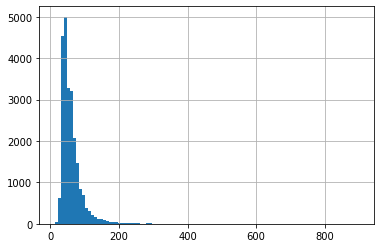

In [197]:
data['total_area'].hist(bins=100);

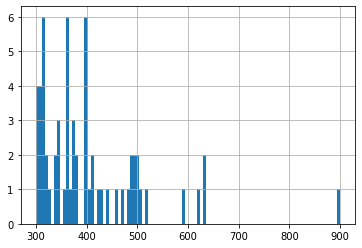

In [198]:
data['total_area'].hist(bins=100, range=(300,900));

In [199]:
#удалим квартиры с площадью более 550 м2
data = data.loc[data['total_area']<550]


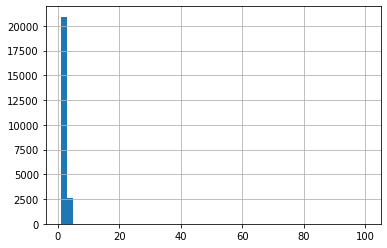

In [200]:
data['ceiling_height'].hist(bins=50);

Высота потолка точно не может быть меньше 2м и вряд ли может быть больше около 20 м
Посмотрим респределение высот на графике

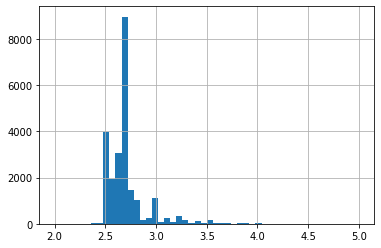

In [201]:
#с ограничением по высоте
data['ceiling_height'].hist(bins=50,range =(2,5));

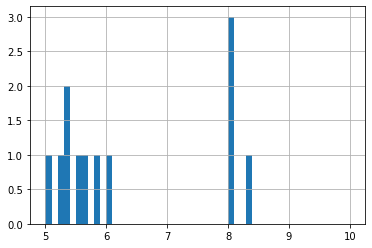

In [202]:
#высокие (без аномальных)
data['ceiling_height'].hist(bins=50,range =(5,10));

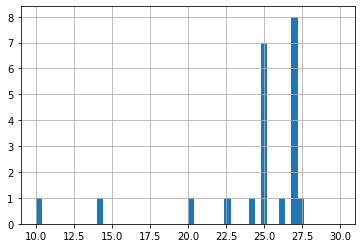

In [203]:
#аномальные
data['ceiling_height'].hist(bins=50,range =(10,30));

Видим, что среднестатистическая высота потолка 2,5 -3.5 метра  
Посчитаем сколько объявлений с высотой менее 2,5 м:


In [204]:
data.loc[data['ceiling_height'] <2.5, 'ceiling_height'].count()

73

Посчитаем сколько объявлений с высотой менее 2,4 м:

In [205]:
data.loc[data['ceiling_height'] <2.4, 'ceiling_height'].count()

21

Поступим следующим образом:  
Высоту 100 метров удалим  
Высоту больше или равно 25 метров разделим на 10, тк можно предположить, что данные были некорректно внесены(напр., 27 метров это 2,7м)  
Удалим объявления с высотой менее 2,4м  
Удалим объявления с высотой больше 20 м


In [206]:
data = data.loc[data['ceiling_height']<100]
data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x/10 if x>=25 else x)
data = data.loc[data['ceiling_height']>=2.4]
data = data.loc[data['ceiling_height']<20]



In [207]:
#посмотрим на объявления с высотой более 10м
display(data.loc[data['ceiling_height']>10])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
9966,19,"5,600,000.00",56.40,2018-05-11,2,14.00,14,32.40,5,0,...,2,Санкт-Петербург,"14,814.00","13,610.00",0.00,NaN,0.00,NaN,315,10096
14755,20,"5,300,000.00",45.00,2017-09-30,1,10.30,16,15.50,15,0,...,0,Санкт-Петербург,"36,353.00","11,936.00",2.00,440.00,2.00,450.00,136,10096


Два объявления в Санкт-Петербурге.  
Теоритически, такая высота может быть в пентхаусе , но площадь должна быть соответсвующая и цена. Думаю можно тоже удалить эти объявления.

In [208]:
data = data.loc[data['ceiling_height']<10]

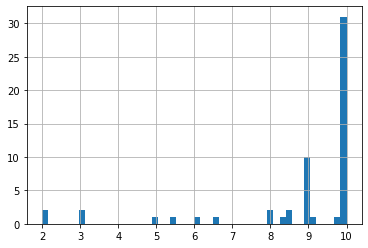

In [209]:
#постотрим на распределния низких значений по жилой площади
data['living_area'].hist(bins=50,range =(2,10));

In [210]:
d = data[['rooms','living_area', 'open_plan', 'is_apartment','studio', 'kitchen_area', ]]
d.loc[d['living_area']<8].sort_values(by='living_area')

,rooms,living_area,open_plan,is_apartment,studio,kitchen_area
9198,2,2.00,False,0,False,9.00
16992,1,2.00,False,0,True,9.00
2104,1,3.00,False,0,False,11.00
15577,3,3.00,False,0,False,16.00
11662,1,5.00,False,0,True,9.00
14513,4,5.40,False,0,False,9.80
10847,1,6.00,False,0,False,17.00
12770,1,6.50,False,0,False,18.00


Смущают низкие значения жилой площади, там где это не студия. (в студии может быть, тк большую часть помещения площадь занимает кухня)  
И тем более, там где более одной комнаты.
Удалим строки там где жилая площадь меньше 7 и это не студия


In [211]:
data = data.loc[(data['living_area']>=7) | (data['studio']==1)]

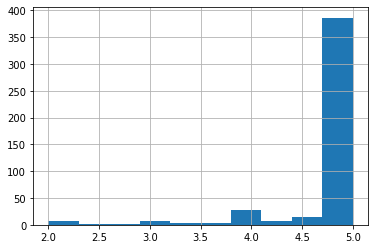

In [212]:
#проверим кухни
data['kitchen_area'].hist(bins=10,range =(2,5));

Видим, что кухни с плащадью 4,5 - 5 метров встречаются достаточно часто  
Кухни с площадью  2-3 метра встречаются в реальности, но это должны быть либо студии либо 1-к апартаменты (похожи на студии)  
Посмотрим на эти объявления: 

In [213]:
d = data[['rooms','living_area', 'open_plan', 'is_apartment','studio', 'kitchen_area', ]]
d.loc[d['kitchen_area']<4].sort_values(by='kitchen_area')

,rooms,living_area,open_plan,is_apartment,studio,kitchen_area
13400,1,19.50,False,0,False,1.30
581,1,18.00,False,0,False,2.00
13016,1,11.00,False,0,False,2.00
10801,1,22.60,False,0,False,2.00
7296,1,16.00,False,0,False,2.00
6034,1,21.00,False,0,False,2.00
14182,1,14.00,False,0,False,2.00
4131,2,16.00,False,0,False,2.00
16893,1,15.50,False,0,False,2.30
17652,1,14.00,False,0,False,2.40


Это не студии, не апартаменты, маловероятно, что это корректные данные.
Удалим их

In [214]:
data = data.loc[(data['kitchen_area']>=4)]

In [215]:
#самое высокое жилое здание в СПБ 37 этажей, удалим, что выше
data = data.loc[(data['floors_total']<40)]

#удалим объявление со стоимостью 12 000
data = data.loc[(data['last_price']>13000)]

Смущает количество балконов более трех, посмотрим распределение

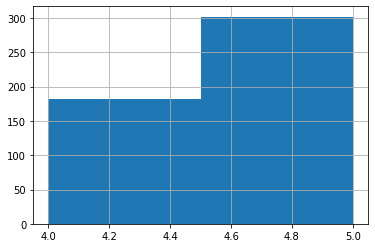

In [216]:
data['balcony'].hist(bins=2,range =(4,5));

In [217]:
#посмотрим объявления с количеством балконов =5 и комнат <5
data.loc[(data['balcony']>4) & (data['rooms']<5)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,count_ad
25,16,"7,900,000.00",74.00,2016-05-04,3,2.70,14,59.00,8,False,...,5,Санкт-Петербург,"37,715.00","12,612.00",1.00,725.00,1.00,759.00,179,10096
67,18,"10,999,000.00",97.20,2017-11-13,3,2.50,16,45.00,16,0,...,5,Санкт-Петербург,"19,426.00","21,138.00",0.00,NaN,2.00,390.00,394,10096
158,2,"14,700,000.00",120.00,2018-09-07,3,2.75,20,63.00,18,0,...,5,Санкт-Петербург,"39,204.00","10,430.00",2.00,627.00,3.00,77.00,61,10096
181,20,"12,500,000.00",86.00,2018-10-19,3,2.80,25,47.00,3,0,...,5,Санкт-Петербург,"52,192.00","15,686.00",0.00,NaN,1.00,441.00,0,10096
201,10,"7,700,000.00",79.00,2019-03-11,3,2.90,12,47.00,11,0,...,5,Санкт-Петербург,"38,622.00","14,116.00",0.00,NaN,0.00,NaN,0,10096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23023,2,"2,500,000.00",56.50,2017-06-13,3,2.50,9,39.80,3,0,...,5,п. Войсковицы,NaN,NaN,NaN,NaN,NaN,NaN,580,6
23105,16,"4,500,000.00",72.00,2018-11-01,2,2.75,7,36.00,7,0,...,5,д. Кузьмолово,NaN,NaN,NaN,NaN,NaN,NaN,0,6
23139,12,"4,200,000.00",74.30,2018-09-24,3,2.70,3,48.50,3,0,...,5,п. Углово,NaN,NaN,NaN,NaN,NaN,NaN,0,4
23165,10,"1,800,000.00",66.30,2019-02-25,3,2.50,5,41.00,2,0,...,5,п. Глажево,NaN,NaN,NaN,NaN,NaN,NaN,0,4


Объявлений достаточно много  
Теоритически, возможно, что квартиры угловые и в каждой комнате по два балкона и бывают еще балконы на кухне  
Оставим эти значения.

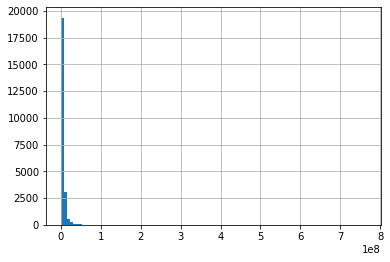

In [218]:
#посмотрим распределения по ценам
data['last_price'].hist(bins=100);

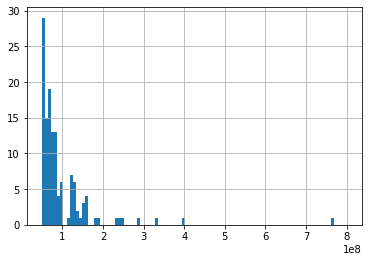

In [219]:
data['last_price'].hist(bins=100,range =(50000000,800000000));

In [220]:
#удалим самую дорогую квартиру
data = data.loc[data['last_price']<700000000]

Посчитаем какой процент данных мы удалили  
В исходном датафрейме было 23699 строк

In [222]:
data.shape[0]

23496

In [223]:
print((23699-data.shape[0])*100/23699)

0.8565762268450146


Было удалено 0,85% данных, что совсем немного

### Добавление новых столбцов, необходимых для анализа

  
* `sqm_price` - цена одного квадратного метра;
* `weekday` - день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
* `month` - месяц публикации объявления;
* `year` - год публикации объявления;
* `floor_type` - тип этажа квартиры (значения — «‎первый», «последний», «другой»);
* `distance` - расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [224]:
data['sqm_price'] = data['last_price']/data['total_area']
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

#функция для заполнения столбца этаж
def floor_type(row):
    floors_total = row['floors_total']
    floor = row['floor']
    try:
        if floor == floors_total:
            return 'последний'
        elif floor == 1:
            return 'первый'
        else:
            return 'другой'                            
    except:
        pass
data['floor_type'] = data.apply(floor_type, axis=1)

data['distance'] = data['cityCenters_nearest']/1000

**Проанализируем показатели**

медиана 52.0
среднее 60.223980251957784


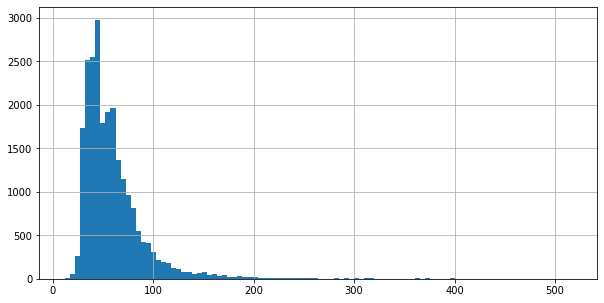

In [225]:
data['total_area'].hist(bins=100,figsize = (10,5));
print('медиана',data['total_area'].median())
print('среднее',data['total_area'].mean())

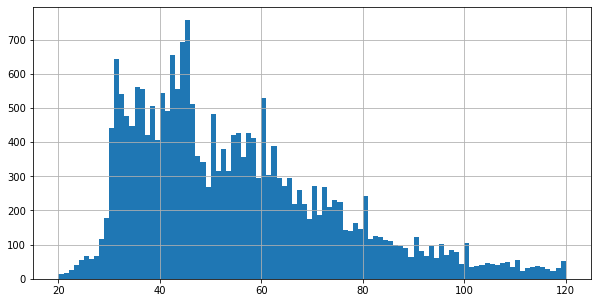

In [226]:
data['total_area'].hist(bins=100, range = (20,120),figsize = (10,5));

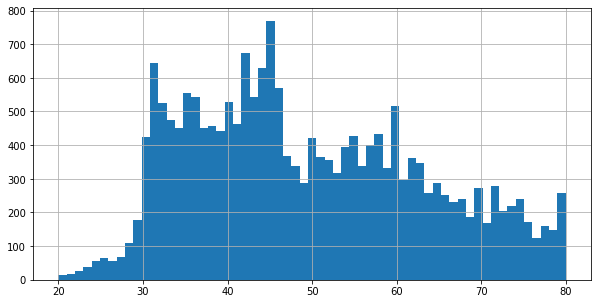

In [227]:
data['total_area'].hist(bins=61, range = (20,80),figsize = (10,5));

Наиболее часто встречаются объявления с общей площадью от 30 до 60 метров квадратных. 
Средняя площадь квартиры 60м2, медианная 50м2.  
Выделяются пики по площади, связанные с типовыми значениями по сериям дома и количеству комнат.  
Это такие значения 31, 42, 45, 60, 70, 80 м2

медиана 30.3
среднее 34.286850379213476


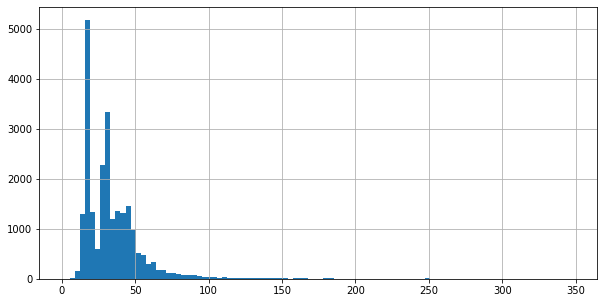

In [228]:
data['living_area'].hist(bins=100,figsize = (10,5));
print('медиана',data['living_area'].median())
print('среднее',data['living_area'].mean())

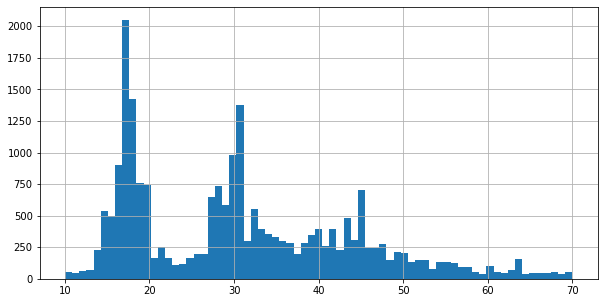

In [229]:
data['living_area'].hist(bins=71, range = (10,70),figsize = (10,5));

Наиболее часто встречаются объявления с жилыми площадями от 15 до 60 метров квадратных.  
Среднее - 30м2, медиана 34м2
Гораздо сильнее выделяются пики по площади, чем в случае общей площади   
Это такие значения как 17, 30, 46, 64 м2  
Вероятно, значения уже не так зависят от типа дома, а в первую очередь от количества комнат.  
Также может быть, что не всегда общая площадь вносится единообразно, кто-то может указывать ее с площадью балкона, а кто-то нет

медиана 9.0
среднее 10.438060520939734


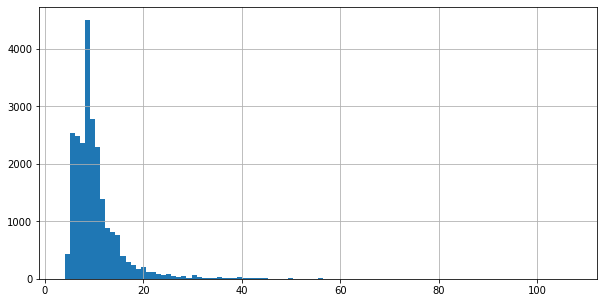

In [230]:
data['kitchen_area'].hist(bins=100,figsize = (10,5));
print('медиана',data['kitchen_area'].median())
print('среднее',data['kitchen_area'].mean())

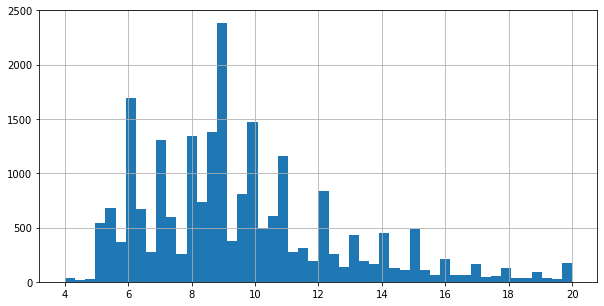

In [231]:
data['kitchen_area'].hist(bins=50, range = (4,20),figsize = (10,5));

Наиболее часто встречаются объявления с площадями кухонь от 6 до 15 метров квадратных.  
Самай типовой размер кухни 9 метров, средний размер - 10м2.

медиана 4650000.0
среднее 6468365.422752809


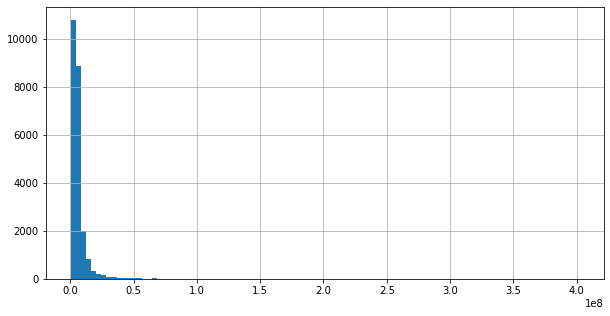

In [232]:
data['last_price'].hist(bins=100,figsize = (10,5));
print('медиана',data['last_price'].median())
print('среднее',data['last_price'].mean())

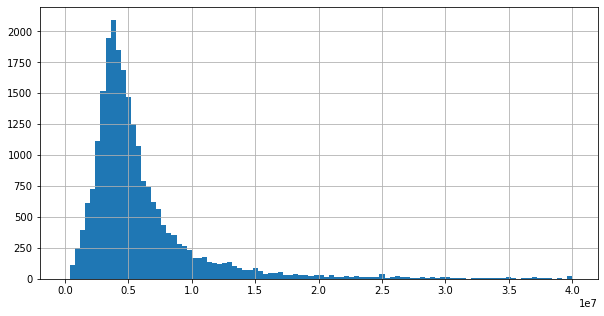

In [233]:
data['last_price'].hist(bins=100, range = (0,40000000),figsize = (10,5));

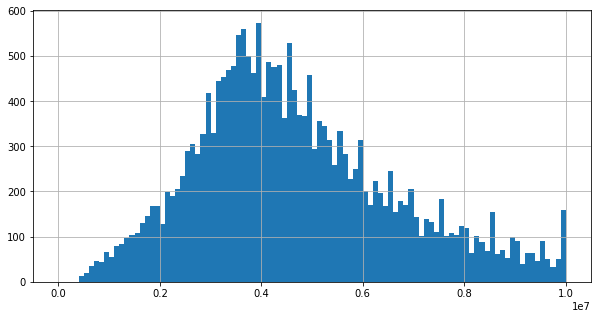

In [234]:
data['last_price'].hist(bins=100, range = (0,10000000),figsize = (10,5))

Основная масса квартир продется по цене от 1 до 10 млн.  
Самые популярные объявления с ценой 3 - 5 млн.  
Медианная цена 4,65 млн, медианная 6,5 млн

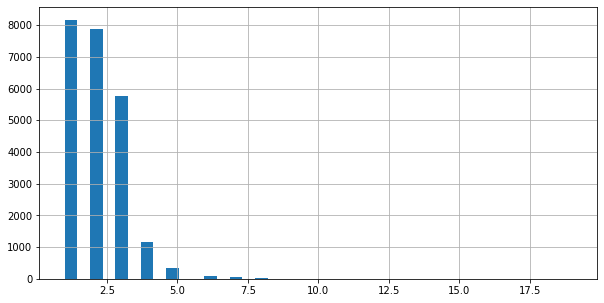

In [235]:
data['rooms'].hist(bins=40,range = (1,19), figsize = (10,5));

Самые популярные предложения на рынке - однушки и двушки, однушек чуть больше.  
Объявлений о продаже квартир с количеством комнат более 5 крайне мало

медиана 2.7
среднее 2.709829971058904


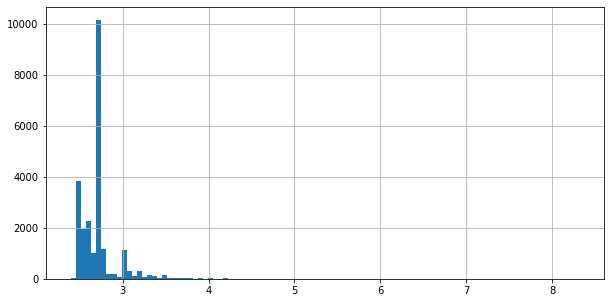

In [236]:
data['ceiling_height'].hist(bins=100,figsize = (10,5));
print('медиана',data['ceiling_height'].median())
print('среднее',data['ceiling_height'].mean())

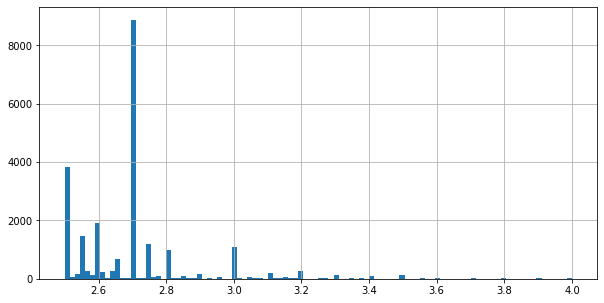

In [237]:
data['ceiling_height'].hist(bins=100, range = (2.5,4),figsize = (10,5));

Средняя и медианная высота потолка 2,7 м. Также распространена высота 2,5 м

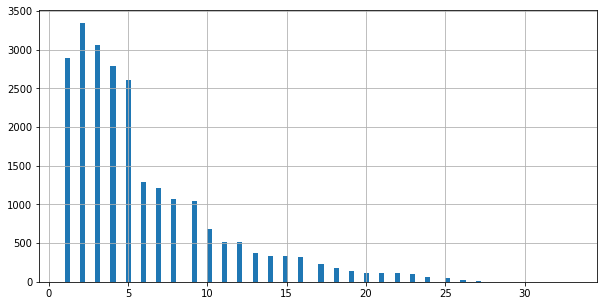

In [238]:
data['floor'].hist(bins=100,figsize = (10,5));

В основном квартиры, которые продаются, находятся на этажах 1-5.  
Это может быть связано также с тем, что большая часть объявлений относится к 5-этажкам.  
Самый популярный этаж - второй

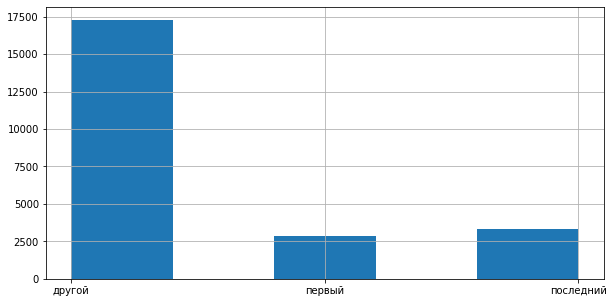

In [239]:
data['floor_type'].hist(bins=5,figsize = (10,5));


На последнем этаже квартиры продаются чаще, чем на первом.

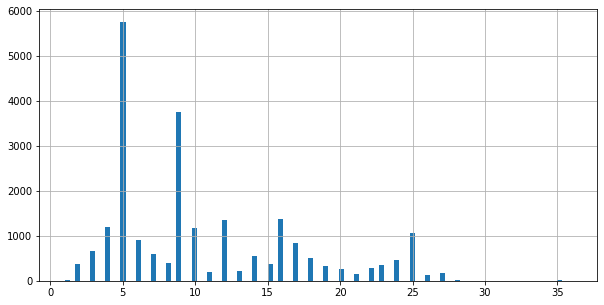

In [240]:
data['floors_total'].hist(bins=100,figsize = (10,5));

Больше всего объявлений о продаже квартир в 5-этажных домах, на втором месте 9-этажные дома

медиана 13105.0
среднее 14198.84006883535


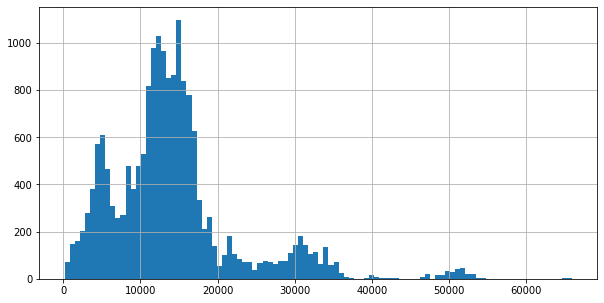

In [241]:
data['cityCenters_nearest'].hist(bins=100,figsize = (10,5));
print('медиана',data['cityCenters_nearest'].median())
print('среднее',data['cityCenters_nearest'].mean())

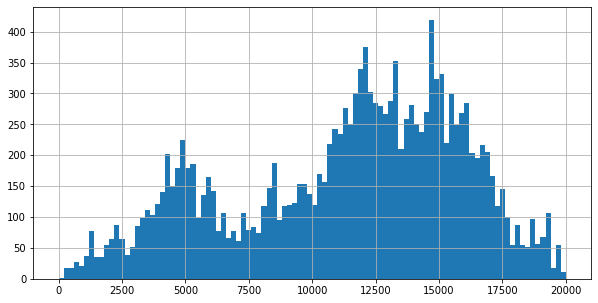

In [242]:
data['cityCenters_nearest'].hist(bins=100, range = (0,20000), figsize = (10,5));

Больше всего объявлений о продаже квартир  с расстоянием до 20 км до центра.  
Выделяется два пика - около 5км и 12-15 км.  
Вероятно это связано с плотносью застройки, одна часть (меньшая) - это застройка в центра, другая - спальные районы.  
Среднее расстояние до центра 14 км.

медиана 26757.0
среднее 28800.437440942693


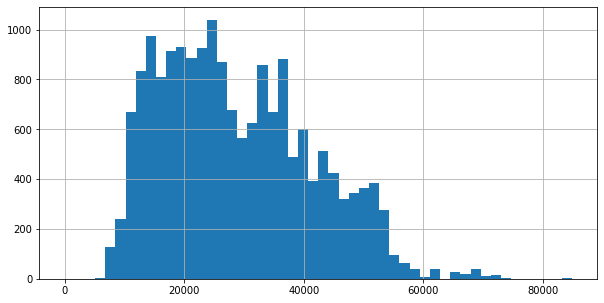

In [243]:
data['airports_nearest'].hist(bins=50,figsize = (10,5));
print('медиана',data['airports_nearest'].median())
print('среднее',data['airports_nearest'].mean())

Так как аэропорты, как правило находятся на окраине, мы не видим здесь нормального распеределения,  
Заметное количество объявлений начинаетя с величины расстояния около 10 км, затем количество объявлений постпенно уменьшется с увеличением расстояния.  
Большинство объявлений находится на расстоянии до 40 км от аэропорта.  
Видим провал на растоянии 30 км - это квартиры в центре - их меньше чем в спальных районах.  
Среднее расстояние до аэропорта 29 км.

медиана 455.0
среднее 490.50174825174827


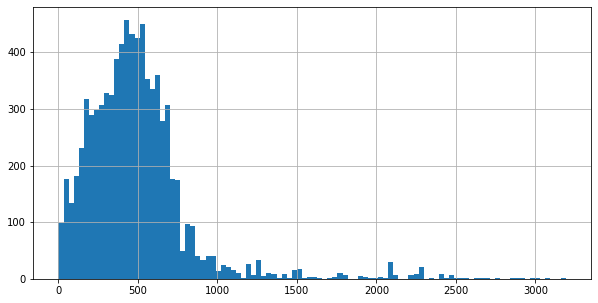

In [244]:
data['parks_nearest'].hist(bins=100,figsize = (10,5));
print('медиана',data['parks_nearest'].median())
print('среднее',data['parks_nearest'].mean())

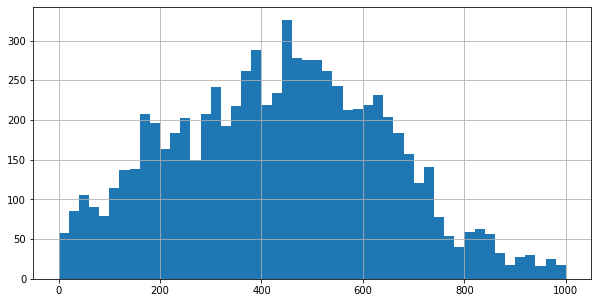

In [245]:
data['parks_nearest'].hist(bins=50, range = (0,1000),figsize = (10,5));

Основная часть квартир находится на расстоянии до 800 м до парка.  
Среднее расстояние квартиры до парка 500 м.

**Оценим влияние даты подачи объявления:**

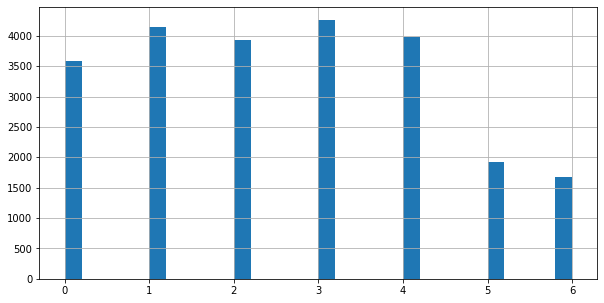

In [246]:
data['weekday'].hist(bins=30,figsize = (10,5));

Большая часть объявлений выставлялась в будние дни.  
Из будней худший день понедельник.  
По выходным суббота выглядит чуть лучше.

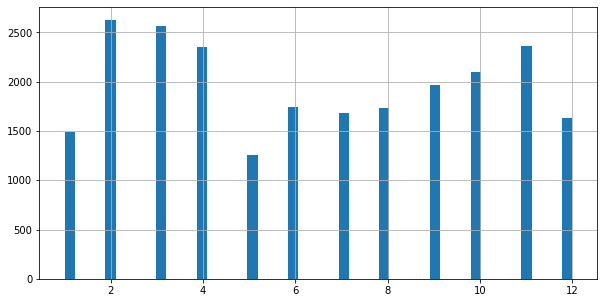

In [247]:
data['month'].hist(bins=50,figsize = (10,5));

Худшие месяцы:  
январь и май, так как в них много выходных  
декабрь, так как все готовятся к праздникам  
летние месяцы, так отпуска и затишье  
Весной объявления подаются активнее, чем осенью  
Общая тенденция - падение количества объявлений с февраля к лету, затем рост до ноября

## Исследовательский анализ данных

**Проанализируем как быстро продавались квартиры**
 
 Построим гистограммы распределения количества объявлений в зависимости от дней размещения  
 и посчитаем среднее и медианное значения

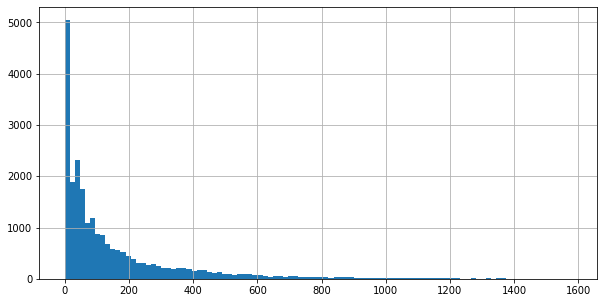

In [248]:
data['days_exposition'].hist(bins=100,figsize = (10,5));

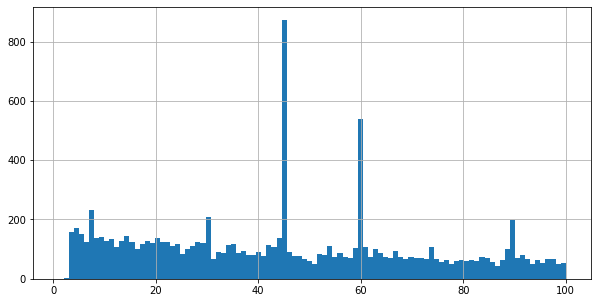

In [249]:
data['days_exposition'].hist(bins=100, range = (1,100),figsize = (10,5));

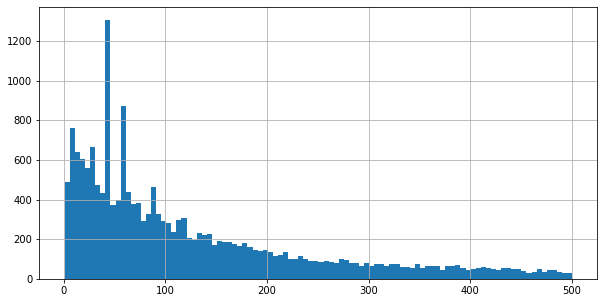

In [250]:
data['days_exposition'].hist(bins=100, range = (1,500),figsize = (10,5));

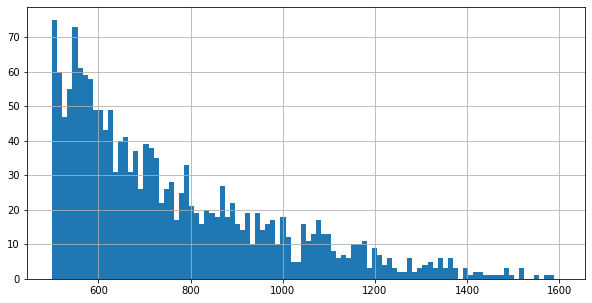

In [251]:
data['days_exposition'].hist(bins=100, range = (500,1600),figsize = (10,5));

In [252]:
print('среднее')
display(data['days_exposition'].mean())
print('медиана')
display(data['days_exposition'].median())
print('75 персентиль')
display(np.percentile (data.days_exposition , 75))
print('30 персентиль')
display(np.percentile (data.days_exposition , 30))




среднее


156.59214334354783

медиана


73.0

75 персентиль


198.0

30 персентиль


33.0

Можно сказать, что как правило продажи занимают до 200 дней.  
Хорошей продажей можно назвать объявление, закрытое за 30 дней.  
Чрезвычайно быстрой - за неделю.  
Некоторые квартиры продаются годами, рекорд 4,5 года.  
Необычно медленные продажи - более 1 года.
Также, наблюдаются пики по количеству закрытых объявлений:  
7, 30, 45, 60, 90 дней.  
Вероятно, это сроки размещения объявлений на сервисе.  
Значит по факту квартиры могут продавться быстрее, тк клиент не закрыл объявление сам, а оно ушло с размещения по окончании срока.


Проверим объявления с нулевым значением дней продаж:

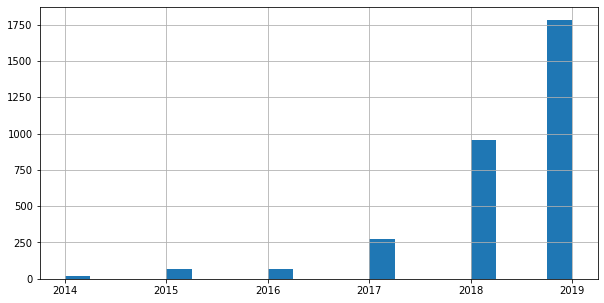

In [253]:
days_zero = data.loc[data['days_exposition'] == 0]
days_zero['year'].hist(bins=20,figsize = (10,5));

Больше всего объявлений с нулевым значением дней продаж принадлежат к последнему году бд.  
Может быть это незакрытые объявления на момент выгрузки данных.


**Проверим связь общей площади и полной стоимости объекта:**


0.6860218260513239


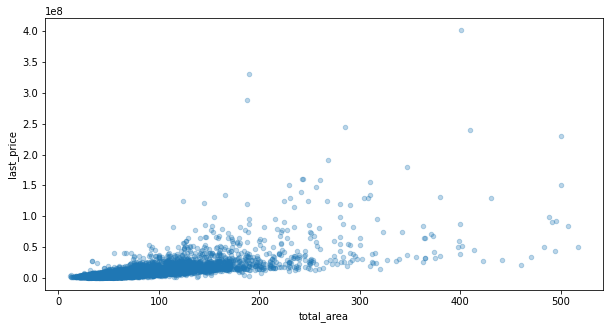

In [254]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.3,figsize = (10,5));
print(data['total_area'].corr(data['last_price']))

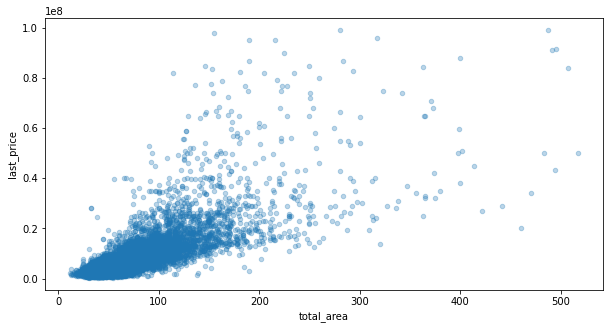

In [255]:
data.query('last_price < 100000000').plot(x='total_area', y='last_price', kind='scatter', alpha=0.3,figsize = (10,5));

Корреляция присутствует, при увеличении общей площади цена увеличивается.  
Причем, если убрать очень дорогие квартиры (более 100 млн), то корреляция заметнее.

In [256]:
#посчитаем корреляцию при полной стоимости менее 100 млн
ta = data.loc[data['last_price']<100000000]
print(ta['total_area'].corr(ta['last_price']))




0.7689145218491801


**Проверим связь жилой площади и полной стоимости объекта:**  

0.583869433887906


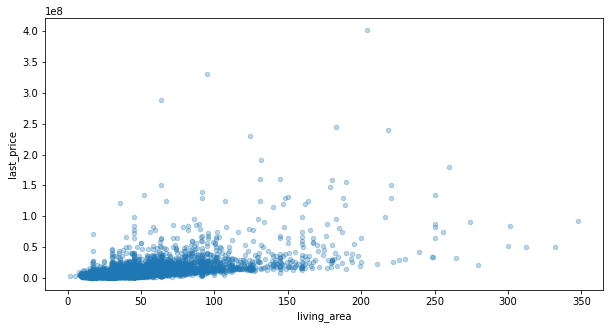

In [257]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.3,figsize = (10,5));
print(data['living_area'].corr(data['last_price']))

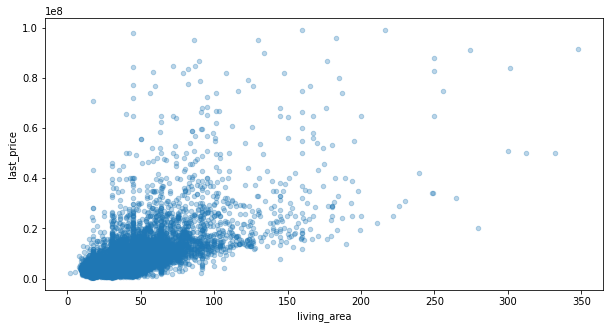

In [258]:
data.query('last_price < 100000000').plot(x='living_area', y='last_price', kind='scatter', alpha=0.3,figsize = (10,5));

Корреляция зависимости цены от жилой площади чуть ниже, чем от общей.  
Также заметнее при меньших стоимостях объекта.

**Проверим связь площади кухни и полной стоимости объекта:**

0.48914349834076193


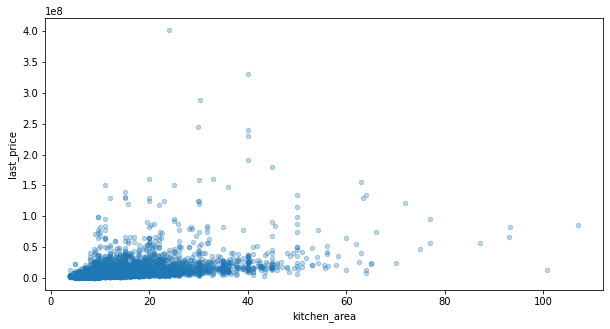

In [259]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3,figsize = (10,5));
print(data['kitchen_area'].corr(data['last_price']))

Корреляция зависимости цены от площади кухни присутствует, но возможно это следствие увеличения площади кухни с увеличением общей площади.

In [260]:
#проверим на уровне количества комнат
r1 = data.loc[data['rooms']==1]
r2 = data.loc[data['rooms']==2]
r3 = data.loc[data['rooms']==3]

0.41188305968834743


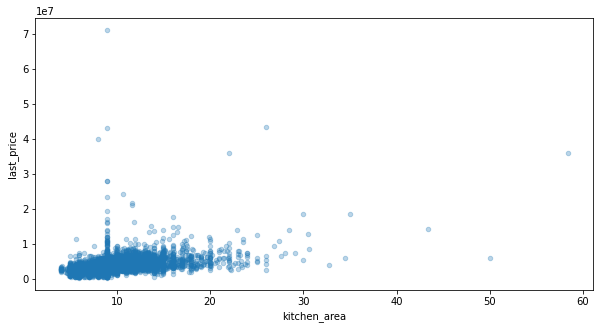

In [261]:
r1.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3,figsize = (10,5));
print(r1['kitchen_area'].corr(r1['last_price']))

0.4620647604846004


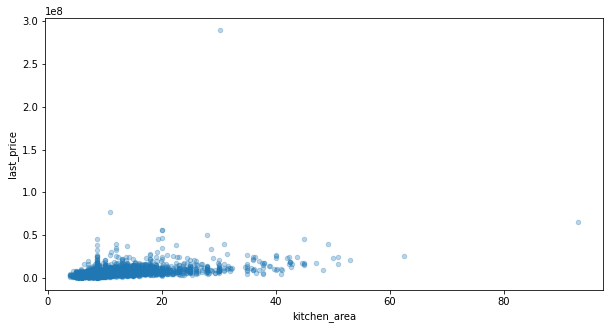

In [262]:
r2.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3,figsize = (10,5));
print(r2['kitchen_area'].corr(r2['last_price']))

0.5048139513083685


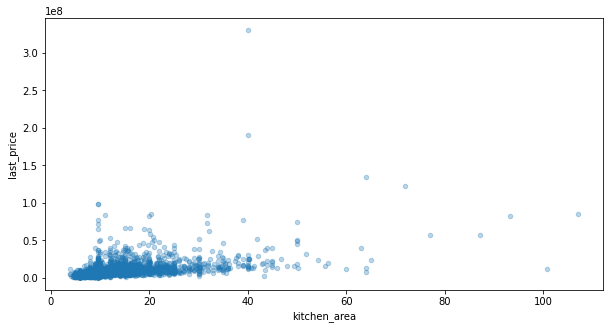

In [263]:
r3.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3,figsize = (10,5));
print(r3['kitchen_area'].corr(r3['last_price']))

0.48914349834076193


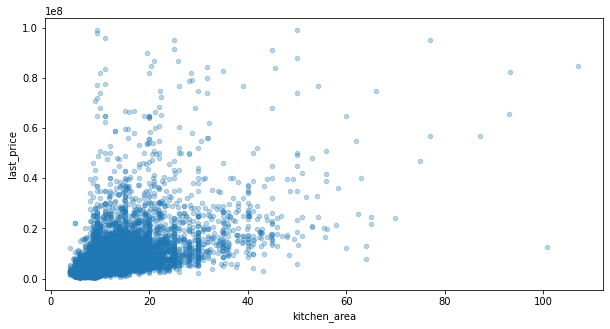

In [264]:
data.query('last_price < 100000000').plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3,figsize = (10,5));
print(data['kitchen_area'].corr(data['last_price']))

При проверки квартир с одинаковым количеством комнат корреляция не изменилась.    
Есть небольшой рост коэффициента с увеличением количества комнат

**Проверим связь количества комнат и полной стоимости объекта:**

0.3923419829743858


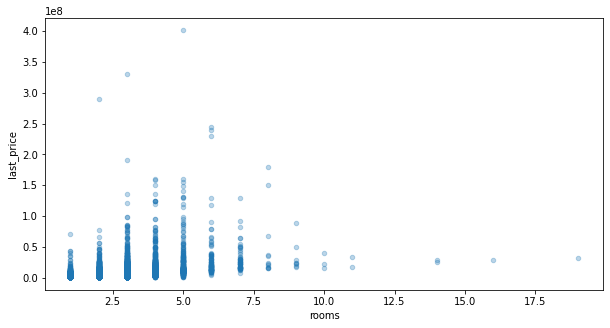

In [265]:
data.query('rooms < 600 and last_price < 500000000').plot(x='rooms', y='last_price', kind='scatter', alpha=0.3,figsize = (10,5));
print(data['rooms'].corr(data['last_price']))

Неинформативный график, тк множество значений относятся к одному и тому же значению комнат.  
Также низкий коэф-т корреляции, что странно, ведь логично предположить, что с увеличением количества комнат цена растет.    
Возможно, это связано что существует большой разброс цен внутри каждой категории по количеству комнат.  

Посчитаем медианы и посмотрим распределние стоимости от количества комнат

In [266]:
d = data.pivot_table(index='rooms', values='last_price', aggfunc='median')
d.reset_index(inplace= True )

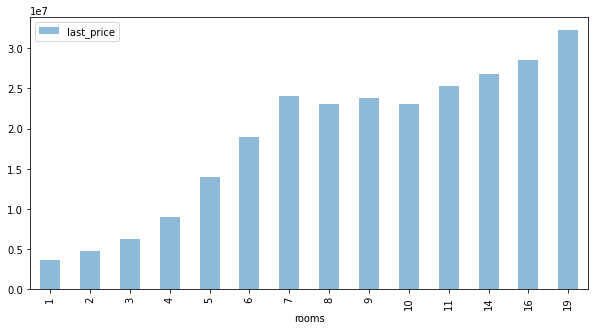

In [267]:
d.plot(x = 'rooms', y='last_price', kind='bar', alpha=0.5,figsize = (10,5));

Видим, что с увеличением кол-ва комнат цена увеличивается, но только до достижения 7 комнат.  
Посчитаем корреляцию выборки квартир от 1 до 7 комнат:

In [268]:
d2 = d.loc[d['rooms']<8]

In [269]:
print(d2['rooms'].corr(d2['last_price']))

0.9697452034481028


Вуаля! Корреляция почти 1!

**Проверим связь даты размещения (день недели, месяц, год) и полной стоимости объекта:**

-0.6727458968385127


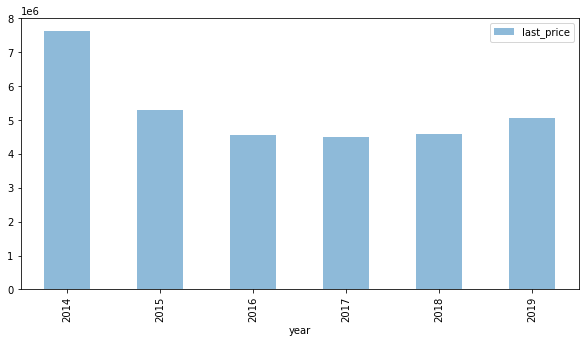

In [270]:
#посчитаем медиану по году:
y = data.pivot_table(index='year', values='last_price', aggfunc='median')
y.reset_index(inplace= True)
y.plot(x = 'year', y='last_price', kind='bar', alpha=0.5,figsize = (10,5));
print(y['year'].corr(y['last_price']))

Корреляция отрицательная, после кризиса 2014 года квартиры заметно подешевели.  
Но видим, что с 2018 начался рост. Может быть связано с уменьшением ипотечных ставок на новостройки, что привело к росту цен на новосроойки и по цепочке на вторичку.  

0.1396084525284569


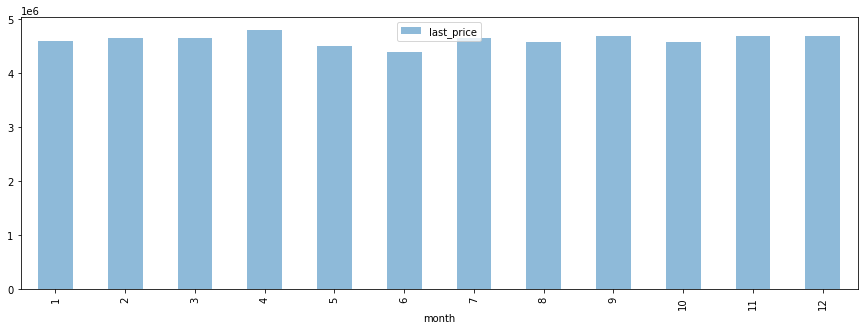

In [271]:
#посчитаем медиану по месяцу:
m = data.pivot_table(index='month', values='last_price', aggfunc='median')
m.reset_index(inplace= True)
m.plot(x = 'month', y='last_price', kind='bar', alpha=0.5,figsize = (15,5));
print(m['month'].corr(m['last_price']))

Корреляция между стоимостью квартиры и месяцем не выражена.  
Есть тенденция роста в начале года с января до апреля.  
Затем падение до июня.  
В конце года рост с октября по декабрь.

-0.826250654832144


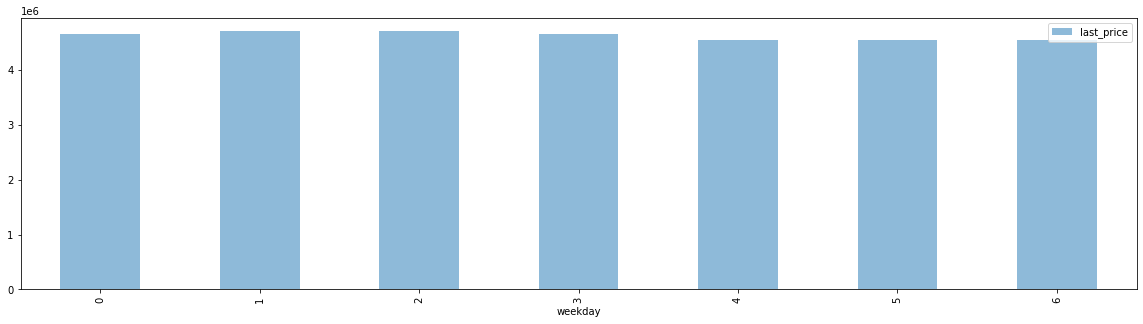

In [272]:
#посчитаем медиану по дню недели:
w = data.pivot_table(index='weekday', values='last_price', aggfunc='median')
w.reset_index(inplace= True)
w.plot(x = 'weekday', y='last_price', kind='bar', alpha=0.5,figsize = (20,5));
print(w['weekday'].corr(w['last_price']))

Если не брать в расчет понедельник, то наблюдается четкая отрицательная зависимость между днем недели и стоимостью квартиры.

**Проверим связь этажа, на котором расположена квартира и полной стоимости объекта:**

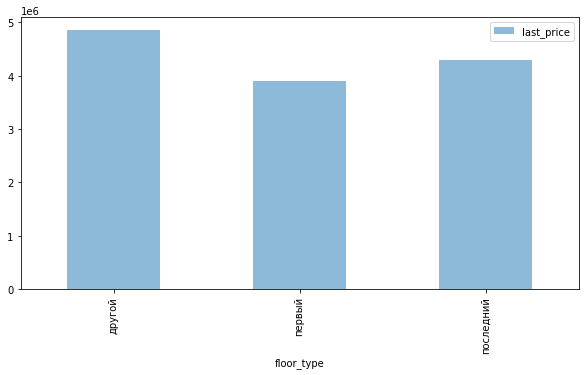

In [273]:
f = data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
f.reset_index(inplace= True)
f.plot(x = 'floor_type', y='last_price', kind='bar', alpha=0.5,figsize = (10,5));


Видим, что этаж напрямую влияет на стоимость квартиры.  
Квартиры на первом и последнем этажах заметно дешевле, чем на остальных.  
На последнем этаже квартиры дороже, чем на первом, что достаточно логично.

**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений   
и посмотрим населённые пункты с самой высокой и низкой стоимостью квадратного метра**

In [280]:
data_top = data.pivot_table(index='locality_name', values='sqm_price', aggfunc=['mean', 'count'])
data_top.reset_index(inplace= True )
data_top.columns = ['locality_name','mean_sqm_price', 'count']
#data_top.query('count >234').sort_values(by='mean_sqm_price')
data_top = data_top.sort_values(by = 'count', ascending=False).head(10)
data_top.sort_values(by = 'mean_sqm_price', ascending=False)

,locality_name,mean_sqm_price,count
33,Санкт-Петербург,"114,638.18",15605
32,Пушкин,"103,081.15",368
17,Кудрово,"95,261.96",469
209,п. Парголово,"90,175.91",327
202,п. Мурино,"85,555.63",550
262,п. Шушары,"78,551.34",439
13,Колпино,"75,424.58",338
6,Гатчина,"68,746.15",307
3,Всеволожск,"68,719.32",397
4,Выборг,"58,238.14",235


Самые высокая цена из топ10 по кол-ву объявлений за 1м2 в Санк-Петербурге, самая низкая в Выборге.

**Посчитаем среднюю цену каждого километра в рамках расстояния от объекта до центра в Санкт-Петербурге:** 

In [275]:

data_spb = data.loc[data['locality_name'] == 'Санкт-Петербург']
data_spb['price_distance'] = data_spb['last_price']/data_spb['distance']


In [276]:
data_spb.sort_values(by='distance').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,count_ad,sqm_price,weekday,month,year,floor_type,distance,price_distance
9054,2,"31,099,000.00",159.00,2018-06-25,5,3.28,5,106.00,5,0,...,426.00,0,10096,"195,591.19",0,6,2018,последний,0.18,"171,817,679.56"
766,1,"5,800,000.00",33.60,2016-03-10,1,3.70,7,22.80,4,False,...,503.00,167,10096,"172,619.05",3,3,2016,другой,0.21,"27,884,615.38"
5677,7,"10,990,000.00",100.00,2015-12-16,3,3.90,5,37.80,3,0,...,511.00,265,10096,"109,900.00",2,12,2015,другой,0.21,"51,116,279.07"
1257,18,"9,590,000.00",108.00,2017-05-23,2,3.30,5,59.00,2,False,...,290.00,69,10096,"88,796.30",1,5,2017,другой,0.29,"33,414,634.15"
13825,18,"11,500,000.00",113.50,2018-09-17,3,4.20,7,44.20,6,0,...,94.00,0,10096,"101,321.59",0,9,2018,другой,0.29,"39,518,900.34"


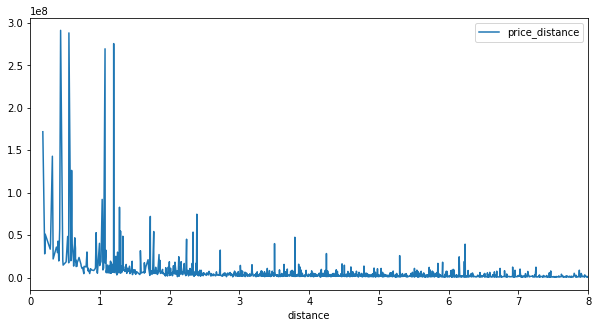

In [277]:
data_spb.pivot_table(index='distance', values='price_distance', aggfunc='mean').plot(xlim = (0,8),figsize = (10,5));


Стоимость объектов снижается при увеличении расстояния от центра города, но только в определенном радиусе  - до 3 км, затем стоимость не меняется.  
Также мы видим, что самые дорогие квартиры всегда находятся рядом с центром, на расстоянии до 1,5 км.  
Можем предположить, что эти пики по стоимости - элитные жк в центре города.  
Также мы помним, что по этим параметрам были пропуски, что могло повлмять на картину.  

## Вывод

**Цель исследования**

Установить параметры, влияющие на рыночную стоимость объектов недвижимости, для последующего создания автоматизированной системы отслеживания аномалий и мошеннической деятельности.  
Для этого мы изучили  базу объявлений о продаже квартир в Санкт-Петербурге и ближайших населенных пунктах  и проанализировали различные параметры.  

В данных были дубликаты, пропуски и аномальные значения.  
Часть пропусков удалось заменить.  
Часть данных удалили - 0,86% строк, из них 0,56% по пропускам, 0,3% по аномальным значениям.   
Много пропусков было по картографическим параметрам, что могло повлиять на результаты. Следует проверить алгоритм формирования этих данных.  

**Основные выводы:**  

Типовая квартира в объявлениях:  
1-2 комнатная квартира, площадью 30-60 м2, с кухней 9 м2, с высотой потолка 2,65 м.  
Находится на 1-5 этажах 5 или 9 этажного дома на расстоянии 12-15 км от центра.   


На **стоимость** влияет:   
* общая и жилая площадь - прямая корреляция, для квартир с ценой до 100 млн, коэффициент Пирсона 0,76
* площадь кухни - в меньшей степени, чем площадь квартиры. Разброс коэффициента от 0,41 до 0,5 на выборках от 1 до 3 комнатных квартир
* количество комнат - прямая зависимость. При количестве комнат до 7 включительно коэффициент Пирсона 0,97!

* этаж - первый и последний дешевле остальных. Последний дороже первого.
* день недели подачи объявления - отрицательная тенденция от вторника к воскресенью, коэффициент Пирсона  --0,84  
* сезон продажи - в мае -июне квартиры продаются дешевле, чем  в другие месяца
* география населенных пунктов - самые дорогие квартиры в Санкт-Петербурге, престижных поселках, таких как Пушкин, Сестрорецк и т.п.  
* расстояние до центра города - в непосредственной близости от центра (до 3км) находятся более дорогие квартиры  
* внешние факторы (изменение курсов валют, изменение кредитных ставок итд)  


На **количество** поданных обявлений влияет:
* день недели - макс. число объявлений выставляется в будни  
* сезон - макс. число объявлений выставляется в феврале-апреле и сентябре - ноябре  


75% объявлений закрывается за полгода, половина за 2 месяца, за месяц закрывактся 30% объявлений.  
